# Designing the Supply Chain for CanDi
## Supply Chain Analytics — Final Project

**CanDi (CandyDistributor)** is a private equity-backed company distributing European soft candies in the US New England states. After 2 years of using expensive 3rd-party distributors, CanDi is building its own supply chain infrastructure.

**Our mandate as supply chain consultants:**

1. **Structural Design** — Where should warehouses be located? How should product flow from port to customer? What transportation modes to use?
2. **Operational Design** — Where is each SKU stocked? What are inventory parameters? How should planning and replenishment work?

---


## Part 1: Setup & Data Loading

We begin by importing all necessary libraries and loading the data provided by CanDi from their Excel workbook. The workbook contains four sheets: **Product** characteristics, **Transportation** costs, **Warehouse** costs, and **Demand** data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Styling
sns.set_theme(style="whitegrid", palette="colorblind")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette for CanDi
CANDI_COLORS = {
    'primary': '#E63946',
    'secondary': '#457B9D',
    'accent': '#F4A261',
    'dark': '#1D3557',
    'light': '#A8DADC',
    'green': '#2A9D8F',
    'purple': '#6A0572'
}
SEGMENT_COLORS = {
    'Mass': '#E63946',
    'Mainline': '#457B9D',
    'Extended': '#F4A261',
    'Tail': '#2A9D8F',
    'Connoisseur': '#6A0572'
}
REGION_COLORS = {'CT': '#E63946', 'MA': '#457B9D', 'ME': '#2A9D8F'}


### 1.1 Product Characteristics

All 110 CanDi SKUs share identical physical characteristics — the only difference is the packaging label. This simplifies logistics significantly since we can treat every unit the same way in terms of handling, stacking, and transportation.


In [2]:
# ── Product characteristics ──
product = {
    'cost_per_bag': 0.80,        # $ per bag
    'sales_price_per_bag': 1.30, # $ per bag
    'bags_per_box': 40,
    'boxes_per_pallet': 30,
    'pallets_per_truck': 20
}

# Derived constants
product['bags_per_pallet'] = product['bags_per_box'] * product['boxes_per_pallet']  # 1,200
product['bags_per_truck'] = product['bags_per_pallet'] * product['pallets_per_truck']  # 24,000
product['boxes_per_truck'] = product['boxes_per_pallet'] * product['pallets_per_truck']  # 600
product['margin_per_bag'] = product['sales_price_per_bag'] - product['cost_per_bag']  # $0.50
product['cost_per_pallet'] = product['cost_per_bag'] * product['bags_per_pallet']  # $960

print("=" * 60)
print("       CANDI PRODUCT CHARACTERISTICS")
print("=" * 60)
for k, v in product.items():
    label = k.replace('_', ' ').title()
    print(f"  {label:.<40} {v:>10,.2f}" if isinstance(v, float) else f"  {label:.<40} {v:>10,}")
print("=" * 60)


       CANDI PRODUCT CHARACTERISTICS
  Cost Per Bag............................       0.80
  Sales Price Per Bag.....................       1.30
  Bags Per Box............................         40
  Boxes Per Pallet........................         30
  Pallets Per Truck.......................         20
  Bags Per Pallet.........................      1,200
  Bags Per Truck..........................     24,000
  Boxes Per Truck.........................        600
  Margin Per Bag..........................       0.50
  Cost Per Pallet.........................     960.00


**Key insight:** Each pallet holds 1,200 bags worth \$960 at cost and \$1,560 at retail. A full truckload carries 24,000 bags (\$19,200 at cost). The \$0.50/bag margin (38.5%) is healthy but must cover all distribution costs — transportation, warehousing, and inventory carrying costs. Every cent per bag in distribution cost matters at scale.


### 1.2 Transportation Costs

CanDi can ship from New York to the three New England states using multiple transportation modes, each with different cost structures and volume requirements.


In [3]:
# ── Transportation costs (NY to each state) ──
transport = pd.DataFrame({
    'Mode': ['UPS', 'LTL', 'FTL'],
    'Unit': ['per box', 'per pallet', 'per truckload'],
    'CT': [8, 150, 500],
    'MA': [8, 200, 700],
    'ME': [8, 250, 1000]
})

leased_truck_cost = 1800  # per day, can make multiple stops

print("Transportation Costs (NY → State):")
print("=" * 65)
display(transport)
print(f"\nLeased Truck: ${leased_truck_cost:,}/day (driver included, multiple stops)")

# ── Normalize all costs to $/bag for comparison ──
transport_per_bag = pd.DataFrame({
    'Mode': ['UPS (1 box)', 'LTL (1 pallet)', 'FTL (full truck)'],
    'Capacity_bags': [
        product['bags_per_box'],       # 40
        product['bags_per_pallet'],    # 1,200
        product['bags_per_truck']      # 24,000
    ],
    'CT_per_bag': [
        8 / product['bags_per_box'],
        150 / product['bags_per_pallet'],
        500 / product['bags_per_truck']
    ],
    'MA_per_bag': [
        8 / product['bags_per_box'],
        200 / product['bags_per_pallet'],
        700 / product['bags_per_truck']
    ],
    'ME_per_bag': [
        8 / product['bags_per_box'],
        250 / product['bags_per_pallet'],
        1000 / product['bags_per_truck']
    ]
})

print("\n\nNormalized Transportation Cost ($ per bag):")
print("=" * 65)
display(transport_per_bag.round(4))


Transportation Costs (NY → State):


,Mode,Unit,CT,MA,ME
0,UPS,per box,8,8,8
1,LTL,per pallet,150,200,250
2,FTL,per truckload,500,700,1000



Leased Truck: $1,800/day (driver included, multiple stops)


Normalized Transportation Cost ($ per bag):


,Mode,Capacity_bags,CT_per_bag,MA_per_bag,ME_per_bag
0,UPS (1 box),40,0.2000,0.2000,0.2000
1,LTL (1 pallet),1200,0.1250,0.1667,0.2083
2,FTL (full truck),24000,0.0208,0.0292,0.0417


**Key insight from a 20-year supply chain perspective:** The economics are dramatic:
- **UPS** at \$0.20/bag eats **40% of the margin** — only viable for tiny emergency shipments
- **LTL** at ~\$0.125–\$0.208/bag is 4–8× cheaper than UPS but still expensive for high-volume SKUs
- **FTL** at ~\$0.021–\$0.042/bag is the clear winner for volume — but you need **24,000 bags to fill a truck**

The fundamental question becomes: *can we aggregate enough volume to consistently fill truckloads?*


### 1.3 Warehouse Costs

CanDi already owns a DC in New York near the port. The question is whether to additionally lease warehouses in CT, MA, and/or ME. These are operated by a logistics provider (3PL).


In [4]:
# ── Warehouse costs (identical for CT, MA, ME) ──
warehouse = {
    'fixed_cost_per_year': 200_000,
    'handling_per_pallet': 12,       # receiving, handling, loading
    'inventory_per_pallet_week': 3,  # storage cost
    'shipping_per_pallet': 15,       # last-mile delivery to customer
    'mixed_pallet_surcharge_per_box': 1  # surcharge for sorting mixed pallets
}

print("Warehouse Costs (per leased DC):")
print("=" * 55)
print(f"  Fixed cost .............. ${warehouse['fixed_cost_per_year']:>12,}/year")
print(f"  Handling ................ ${warehouse['handling_per_pallet']:>12}/pallet")
print(f"  Inventory holding ....... ${warehouse['inventory_per_pallet_week']:>12}/pallet/week")
print(f"  Shipping to customer .... ${warehouse['shipping_per_pallet']:>12}/pallet")
print(f"  Mixed pallet surcharge  ${warehouse['mixed_pallet_surcharge_per_box']:>10}/box")

# Per-bag warehouse costs
wh_handling_per_bag = warehouse['handling_per_pallet'] / product['bags_per_pallet']
wh_shipping_per_bag = warehouse['shipping_per_pallet'] / product['bags_per_pallet']
wh_inventory_per_bag_week = warehouse['inventory_per_pallet_week'] / product['bags_per_pallet']
wh_surcharge_per_bag = warehouse['mixed_pallet_surcharge_per_box'] / product['bags_per_box']
print(f"\n  Handling per bag:        ${wh_handling_per_bag:.4f}")
print(f"  Shipping per bag:        ${wh_shipping_per_bag:.4f}")
print(f"  Inventory per bag/week:  ${wh_inventory_per_bag_week:.4f}")
print(f"  Surcharge per bag:       ${wh_surcharge_per_bag:.4f}  (if on a mixed pallet)")
print(f"\n  The surcharge of $1/box ($0.025/bag) is charged when the DC")
print(f"  receives pallets containing multiple SKUs that need sorting.")
print(f"  This primarily impacts low-volume SKUs (Tail, Connoisseur)")
print(f"  that cannot fill full pallets of a single SKU.")

Warehouse Costs (per leased DC):
  Fixed cost .............. $     200,000/year
  Handling ................ $          12/pallet
  Inventory holding ....... $           3/pallet/week
  Shipping to customer .... $          15/pallet
  Mixed pallet surcharge  $         1/box

  Handling per bag:        $0.0100
  Shipping per bag:        $0.0125
  Inventory per bag/week:  $0.0025
  Surcharge per bag:       $0.0250  (if on a mixed pallet)

  The surcharge of $1/box ($0.025/bag) is charged when the DC
  receives pallets containing multiple SKUs that need sorting.
  This primarily impacts low-volume SKUs (Tail, Connoisseur)
  that cannot fill full pallets of a single SKU.


**Key insight:** Warehouse variable costs add about \$0.0225/bag for handling + customer delivery (\$0.01 + \$0.0125). However, the **\$1/box mixed pallet surcharge** adds \$0.025/bag — more than doubling handling costs for SKUs that ship on mixed pallets!

This surcharge is critical: when NY replenishes a regional DC, high-volume SKUs (Mass, Mainline) can fill full single-SKU pallets and avoid the surcharge. But low-volume SKUs (Tail at 270-450 bags/SKU/week, Connoisseur at 60-90 bags/SKU/week) will almost always ship on mixed pallets, incurring the full \$1/box surcharge on every box. This creates a **strong economic penalty for stocking long-tail SKUs at regional DCs**.


### 1.4 Demand Data

The demand data is the heart of this analysis. CanDi's 110 SKUs fall into 5 segments with distinct demand profiles. Critically:
- **Normal retail customers** (Mass, Mainline, Extended, Tail): A customer offering a lower segment also offers every segment above it
- **Connoisseur customers**: Buy *only* Connoisseur SKUs — they are a separate customer base

This customer nesting structure has important implications for order consolidation and delivery efficiency.


In [5]:
# ── Demand data ──
demand = pd.DataFrame({
    'Segment': ['Mass', 'Mainline', 'Extended', 'Tail', 'Connoisseur'],
    'Num_SKUs': [10, 15, 30, 50, 5],
    'Mean_bags_per_cust_week_sku': [100, 75, 40, 15, 10],
    'CV': [0.2, 0.3, 0.4, 0.6, 0.4],   # Coefficient of Variation
    'Customers_CT': [30, 30, 30, 18, 6],
    'Customers_MA': [60, 60, 45, 30, 9],
    'Customers_ME': [4, 4, 2, 0, 2]
})

# Standard deviation = CV * Mean
demand['Stdev_bags_per_cust_week_sku'] = demand['CV'] * demand['Mean_bags_per_cust_week_sku']

print("Demand Data (per SKU, per customer, per week):")
print("=" * 85)
display(demand)
print(f"\nTotal SKUs: {demand['Num_SKUs'].sum()}")
print("\nNote: Stdev column in data represents Coefficient of Variation (CV = σ/μ)")


Demand Data (per SKU, per customer, per week):


,Segment,Num_SKUs,Mean_bags_per_cust_week_sku,CV,Customers_CT,Customers_MA,Customers_ME,Stdev_bags_per_cust_week_sku
0,Mass,10,100,0.2,30,60,4,20.0
1,Mainline,15,75,0.3,30,60,4,22.5
2,Extended,30,40,0.4,30,45,2,16.0
3,Tail,50,15,0.6,18,30,0,9.0
4,Connoisseur,5,10,0.4,6,9,2,4.0



Total SKUs: 110

Note: Stdev column in data represents Coefficient of Variation (CV = σ/μ)


In [6]:
# ── Compute TOTAL weekly demand in bags, by segment and region ──
regions = ['CT', 'MA', 'ME']

# Total bags per week per segment per region = Mean * Customers * Num_SKUs
total_demand_rows = []
for _, row in demand.iterrows():
    for reg in regions:
        cust_col = f'Customers_{reg}'
        total_bags_week = row['Mean_bags_per_cust_week_sku'] * row[cust_col] * row['Num_SKUs']
        total_demand_rows.append({
            'Segment': row['Segment'],
            'Region': reg,
            'Num_SKUs': row['Num_SKUs'],
            'Customers': row[cust_col],
            'Bags_per_cust_week_sku': row['Mean_bags_per_cust_week_sku'],
            'Total_bags_week': total_bags_week,
            'Total_boxes_week': total_bags_week / product['bags_per_box'],
            'Total_pallets_week': total_bags_week / product['bags_per_pallet'],
        })

demand_total = pd.DataFrame(total_demand_rows)
demand_total['Total_revenue_week'] = demand_total['Total_bags_week'] * product['sales_price_per_bag']
demand_total['Total_cost_week'] = demand_total['Total_bags_week'] * product['cost_per_bag']

print("TOTAL WEEKLY DEMAND BY SEGMENT & REGION:")
print("=" * 90)
display(demand_total[['Segment', 'Region', 'Customers', 'Total_bags_week', 
                       'Total_boxes_week', 'Total_pallets_week', 'Total_revenue_week']].round(1))


TOTAL WEEKLY DEMAND BY SEGMENT & REGION:


,Segment,Region,Customers,Total_bags_week,Total_boxes_week,Total_pallets_week,Total_revenue_week
0,Mass,CT,30,30000,750.0,25.0,39000.0
1,Mass,MA,60,60000,1500.0,50.0,78000.0
2,Mass,ME,4,4000,100.0,3.3,5200.0
3,Mainline,CT,30,33750,843.8,28.1,43875.0
4,Mainline,MA,60,67500,1687.5,56.2,87750.0
5,Mainline,ME,4,4500,112.5,3.8,5850.0
6,Extended,CT,30,36000,900.0,30.0,46800.0
7,Extended,MA,45,54000,1350.0,45.0,70200.0
8,Extended,ME,2,2400,60.0,2.0,3120.0
9,Tail,CT,18,13500,337.5,11.2,17550.0


In [7]:
# ── Summary by region ──
region_summary = demand_total.groupby('Region').agg(
    Total_bags_week=('Total_bags_week', 'sum'),
    Total_boxes_week=('Total_boxes_week', 'sum'),
    Total_pallets_week=('Total_pallets_week', 'sum'),
    Total_revenue_week=('Total_revenue_week', 'sum')
).round(1)

region_summary['Truckloads_week'] = (region_summary['Total_pallets_week'] / product['pallets_per_truck']).round(2)
region_summary['Annual_revenue'] = region_summary['Total_revenue_week'] * 52

print("WEEKLY & ANNUAL DEMAND SUMMARY BY REGION:")
print("=" * 80)
display(region_summary)

total_bags = demand_total['Total_bags_week'].sum()
total_pallets = total_bags / product['bags_per_pallet']
total_trucks = total_pallets / product['pallets_per_truck']
total_annual_rev = total_bags * product['sales_price_per_bag'] * 52

print(f"\nGRAND TOTAL (ALL REGIONS):")
print(f"   Weekly:  {total_bags:>12,.0f} bags | {total_pallets:>8,.1f} pallets | {total_trucks:>6,.2f} truckloads")
print(f"   Annual:  {total_bags*52:>12,.0f} bags | Revenue: ${total_annual_rev:>12,.0f}")


WEEKLY & ANNUAL DEMAND SUMMARY BY REGION:


,Total_bags_week,Total_boxes_week,Total_pallets_week,Total_revenue_week,Truckloads_week,Annual_revenue
Region,,,,,,
CT,113550,2838.8,94.6,147615.0,4.73,7675980.0
MA,204450,5111.2,170.4,265785.0,8.52,13820820.0
ME,11000,275.0,9.2,14300.0,0.46,743600.0



GRAND TOTAL (ALL REGIONS):
   Weekly:       329,000 bags |    274.2 pallets |  13.71 truckloads
   Annual:    17,108,000 bags | Revenue: $  22,240,400


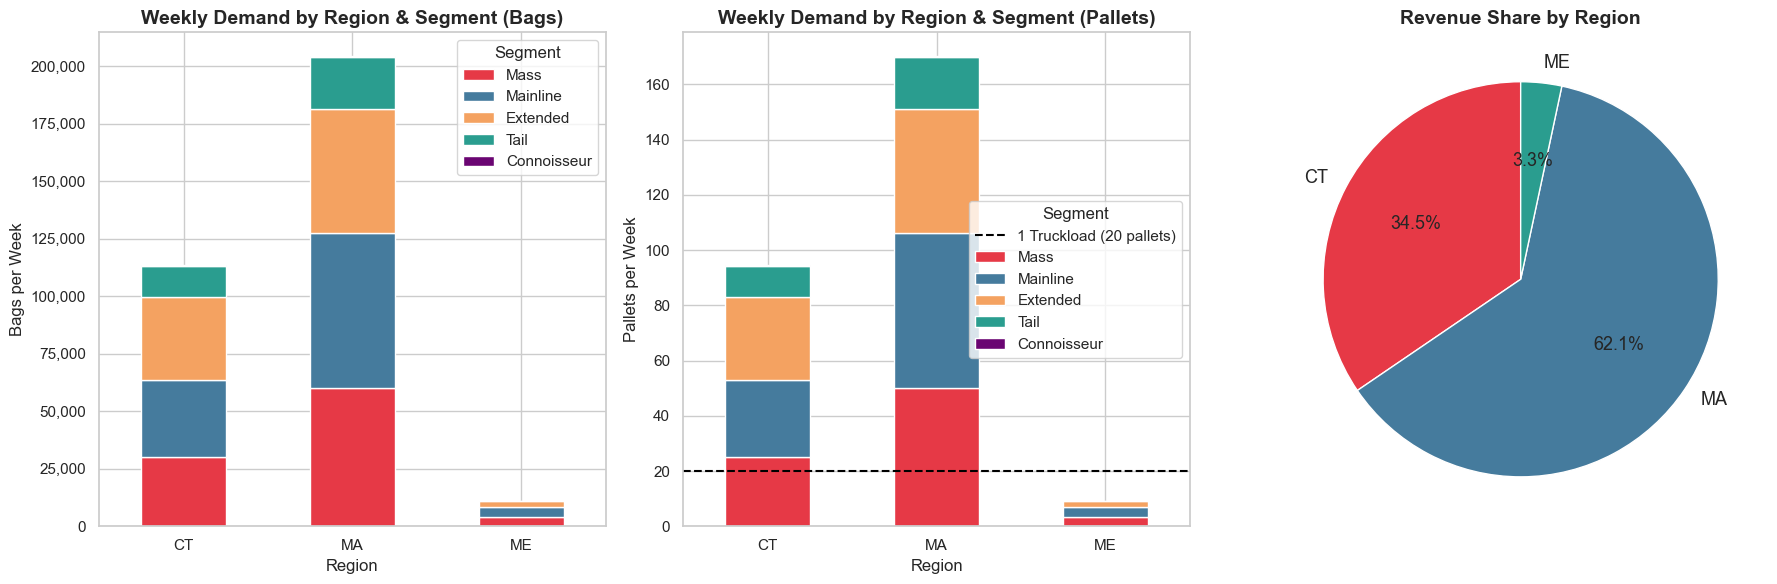

In [8]:
# ── Visualization: Demand distribution ──
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1) Total bags by segment and region (stacked bar)
pivot_bags = demand_total.pivot_table(index='Region', columns='Segment', values='Total_bags_week', aggfunc='sum')
pivot_bags = pivot_bags[['Mass', 'Mainline', 'Extended', 'Tail', 'Connoisseur']]
pivot_bags.plot(kind='bar', stacked=True, ax=axes[0], 
                color=[SEGMENT_COLORS[s] for s in pivot_bags.columns])
axes[0].set_title('Weekly Demand by Region & Segment (Bags)', fontweight='bold')
axes[0].set_ylabel('Bags per Week')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='Segment', bbox_to_anchor=(1.0, 1.0))
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# 2) Pallets by region (shows trucking needs)
pivot_pallets = demand_total.pivot_table(index='Region', columns='Segment', values='Total_pallets_week', aggfunc='sum')
pivot_pallets = pivot_pallets[['Mass', 'Mainline', 'Extended', 'Tail', 'Connoisseur']]
pivot_pallets.plot(kind='bar', stacked=True, ax=axes[1],
                   color=[SEGMENT_COLORS[s] for s in pivot_pallets.columns])
axes[1].set_title('Weekly Demand by Region & Segment (Pallets)', fontweight='bold')
axes[1].set_ylabel('Pallets per Week')
axes[1].tick_params(axis='x', rotation=0)
axes[1].axhline(y=20, color='black', linestyle='--', linewidth=1.5, label='1 Truckload (20 pallets)')
axes[1].legend(title='Segment')

# 3) Pie chart of revenue by region
rev_by_region = demand_total.groupby('Region')['Total_revenue_week'].sum()
axes[2].pie(rev_by_region, labels=rev_by_region.index, autopct='%1.1f%%',
            colors=[REGION_COLORS[r] for r in rev_by_region.index],
            startangle=90, textprops={'fontsize': 13})
axes[2].set_title('Revenue Share by Region', fontweight='bold')

plt.tight_layout()
plt.show()

### 1.5 Per-Customer Volume Analysis (Critical for Transportation!)

The PDF specifies that CanDi delivers to **customer DCs** — each customer has one DC per state. FTL is **point-to-point** (one destination). This means we must understand per-customer volume to determine which transport modes are even feasible.

Key nesting rule: a customer that carries a lower segment also carries every segment above it (except Connoisseur — separate customers).


In [9]:
# ══════════════════════════════════════════════════════════════
# PER-CUSTOMER VOLUME ANALYSIS (NESTING LOGIC)
# ══════════════════════════════════════════════════════════════

# Customer nesting: Tail customers also carry Extended+Mainline+Mass
# Connoisseur customers are SEPARATE — they only buy Connoisseur

customer_types = {}
for reg in regions:
    n_mass = demand.loc[demand['Segment']=='Mass', f'Customers_{reg}'].values[0]
    n_mainline = demand.loc[demand['Segment']=='Mainline', f'Customers_{reg}'].values[0]
    n_extended = demand.loc[demand['Segment']=='Extended', f'Customers_{reg}'].values[0]
    n_tail = demand.loc[demand['Segment']=='Tail', f'Customers_{reg}'].values[0]
    n_connoisseur = demand.loc[demand['Segment']=='Connoisseur', f'Customers_{reg}'].values[0]
    
    types = []
    
    # Tail customers (carry ALL 4 normal segments)
    if n_tail > 0:
        bags = 10*100 + 15*75 + 30*40 + 50*15  # Mass+Mainline+Extended+Tail
        types.append({
            'Type': 'Tail (all 4 segments)', 'Count': n_tail,
            'Segments': 'Mass+Mainline+Extended+Tail', 'SKUs': 105,
            'Bags_per_cust_week': bags,
            'Boxes_per_cust_week': bags / product['bags_per_box'],
            'Pallets_per_cust_week': bags / product['bags_per_pallet']
        })
    
    # Extended-only customers (carry Mass+Mainline+Extended, NOT Tail)
    n_ext_only = n_extended - n_tail
    if n_ext_only > 0:
        bags = 10*100 + 15*75 + 30*40
        types.append({
            'Type': 'Extended (top 3 segments)', 'Count': n_ext_only,
            'Segments': 'Mass+Mainline+Extended', 'SKUs': 55,
            'Bags_per_cust_week': bags,
            'Boxes_per_cust_week': bags / product['bags_per_box'],
            'Pallets_per_cust_week': bags / product['bags_per_pallet']
        })
    
    # Mainline-only customers
    n_main_only = n_mainline - n_extended
    if n_main_only > 0:
        bags = 10*100 + 15*75
        types.append({
            'Type': 'Mainline (top 2 segments)', 'Count': n_main_only,
            'Segments': 'Mass+Mainline', 'SKUs': 25,
            'Bags_per_cust_week': bags,
            'Boxes_per_cust_week': bags / product['bags_per_box'],
            'Pallets_per_cust_week': bags / product['bags_per_pallet']
        })
    
    # Mass-only customers
    n_mass_only = n_mass - n_mainline
    if n_mass_only > 0:
        bags = 10*100
        types.append({
            'Type': 'Mass only', 'Count': n_mass_only,
            'Segments': 'Mass', 'SKUs': 10,
            'Bags_per_cust_week': bags,
            'Boxes_per_cust_week': bags / product['bags_per_box'],
            'Pallets_per_cust_week': bags / product['bags_per_pallet']
        })
    
    # Connoisseur customers (SEPARATE)
    if n_connoisseur > 0:
        bags = 5*10
        types.append({
            'Type': 'Connoisseur only', 'Count': n_connoisseur,
            'Segments': 'Connoisseur', 'SKUs': 5,
            'Bags_per_cust_week': bags,
            'Boxes_per_cust_week': bags / product['bags_per_box'],
            'Pallets_per_cust_week': bags / product['bags_per_pallet']
        })
    
    customer_types[reg] = types

# Display
for reg in regions:
    print(f"\n{'='*80}")
    print(f"  {reg} — CUSTOMER TYPES & WEEKLY ORDER SIZES")
    print(f"{'='*80}")
    total_custs = 0
    for ct in customer_types[reg]:
        total_custs += ct['Count']
        print(f"  {ct['Count']:>3} customers | {ct['Type']:<30} | "
              f"{ct['Bags_per_cust_week']:>6,.0f} bags | "
              f"{ct['Boxes_per_cust_week']:>6.1f} boxes | "
              f"{ct['Pallets_per_cust_week']:>5.2f} pallets")
    print(f"  {'─'*75}")
    print(f"  {total_custs:>3} total unique customer DCs to deliver to")
    
    max_pallets = max(ct['Pallets_per_cust_week'] for ct in customer_types[reg])
    print(f"\n  Largest customer order: {max_pallets:.2f} pallets/week")
    print(f"      FTL truck capacity: {product['pallets_per_truck']} pallets")
    print(f"      → NO customer can fill a full truck! FTL (point-to-point) is NOT viable for direct delivery.")



  CT — CUSTOMER TYPES & WEEKLY ORDER SIZES
   18 customers | Tail (all 4 segments)          |  4,075 bags |  101.9 boxes |  3.40 pallets
   12 customers | Extended (top 3 segments)      |  3,325 bags |   83.1 boxes |  2.77 pallets
    6 customers | Connoisseur only               |     50 bags |    1.2 boxes |  0.04 pallets
  ───────────────────────────────────────────────────────────────────────────
   36 total unique customer DCs to deliver to

  Largest customer order: 3.40 pallets/week
      FTL truck capacity: 20 pallets
      → NO customer can fill a full truck! FTL (point-to-point) is NOT viable for direct delivery.

  MA — CUSTOMER TYPES & WEEKLY ORDER SIZES
   30 customers | Tail (all 4 segments)          |  4,075 bags |  101.9 boxes |  3.40 pallets
   15 customers | Extended (top 3 segments)      |  3,325 bags |   83.1 boxes |  2.77 pallets
   15 customers | Mainline (top 2 segments)      |  2,125 bags |   53.1 boxes |  1.77 pallets
    9 customers | Connoisseur only         

### ⚠️ Critical Insight: FTL Cannot Be Used for Direct-to-Customer

The largest customer order is only **3.40 pallets/week** (a Tail customer carrying all 4 segments). A full truckload holds **20 pallets**. This means:

- **FTL (point-to-point at \$500-\$1,000/truck)** → **CANNOT be used** for direct customer delivery. The truck would be 83% empty.
- **LTL (\$150-\$250/pallet)** → The realistic option for direct customer delivery
- **Leased truck (\$1,800/day, multi-stop)** → Alternative; can carry 20 pallets across ~6 stops

However, FTL **CAN** be used from NY to a **regional DC**, because all customer volume for that state aggregates at the DC (86-170 pallets/week = 4-8+ full trucks).

**This is the fundamental economic driver for regional DCs:** They enable cheap FTL trunk-line shipping that is impossible when delivering directly to individual customers.

---


### Demand Analysis — Key Takeaways

**Massachusetts (MA) dominates** with ~63% of total volume and revenue. This is by far the most important market.

**Connecticut (CT)** is the second-largest market (~33%), while **Maine (ME)** is very small (~4%).

**In pallet terms (critical for transportation planning):**
- **MA**: ~163 pallets/week ≈ **8.2 full truckloads/week** — massive, consistent volume
- **CT**: ~86 pallets/week ≈ **4.3 full truckloads/week** — solid volume
- **ME**: ~6 pallets/week ≈ **0.3 truckloads/week** — tiny; less than a single truckload

This immediately tells us that **FTL shipping to MA and CT is clearly feasible**, while **ME will require LTL or consolidation strategies**.

---


## Part 2: Transportation Cost Deep-Dive

Before deciding on warehouse locations, we need to understand the true cost of each transportation option at the actual volumes CanDi ships. This is where many supply chain decisions go wrong — companies pick modes based on rate cards without considering their actual shipment profiles.


In [10]:
# ══════════════════════════════════════════════════════════════
# CORRECTED TRANSPORTATION COST — DIRECT FROM NY vs VIA REGIONAL DC
# ══════════════════════════════════════════════════════════════
# CRITICAL: Direct-to-customer cannot use FTL (point-to-point) because
# no single customer fills a truck. Must use LTL or leased truck.
# FTL is only viable for NY → Regional DC (aggregated volume).

transport_comparison = []

for reg in regions:
    reg_demand_data = demand_total[demand_total['Region'] == reg]
    total_bags = reg_demand_data['Total_bags_week'].sum()
    total_pallets = total_bags / product['bags_per_pallet']
    total_boxes = total_bags / product['bags_per_box']
    
    # Count unique customer DCs
    n_normal = demand.loc[demand['Segment']=='Mass', f'Customers_{reg}'].values[0]
    n_connoisseur = demand.loc[demand['Segment']=='Connoisseur', f'Customers_{reg}'].values[0]
    total_customer_dcs = n_normal + n_connoisseur
    
    ups_rate = 8
    ltl_rate = {'CT': 150, 'MA': 200, 'ME': 250}[reg]
    ftl_rate = {'CT': 500, 'MA': 700, 'ME': 1000}[reg]
    
    # ── OPTION A: Direct via UPS (per box) ──
    ups_cost = total_boxes * ups_rate
    
    # ── OPTION B: Direct via LTL (per pallet, to each customer) ──
    # Each customer's pallets shipped individually via LTL
    ltl_pallets = int(np.ceil(total_pallets))
    ltl_cost = ltl_pallets * ltl_rate
    
    # ── OPTION C: Direct via Leased Truck (multi-stop) ──
    # $1,800/day, 20 pallets capacity, can make multiple stops
    leased_trucks_needed = int(np.ceil(total_pallets / product['pallets_per_truck']))
    leased_cost = leased_trucks_needed * leased_truck_cost
    
    # ── OPTION D: Via Regional DC ──
    # NY → DC: FTL for full trucks + LTL for remainder
    full_trucks_dc = int(total_pallets // product['pallets_per_truck'])
    rem_pallets_dc = total_pallets - full_trucks_dc * product['pallets_per_truck']
    ny_to_dc_cost = full_trucks_dc * ftl_rate + (int(np.ceil(rem_pallets_dc)) * ltl_rate if rem_pallets_dc > 0 else 0)
    # DC → Customer: $15/pallet (3PL handles delivery)
    dc_to_cust_cost = int(np.ceil(total_pallets)) * warehouse['shipping_per_pallet']
    dc_total_transport = ny_to_dc_cost + dc_to_cust_cost
    
    transport_comparison.append({
        'Region': reg,
        'Customer_DCs': total_customer_dcs,
        'Weekly_bags': total_bags,
        'Weekly_pallets': round(total_pallets, 1),
        'A_UPS': ups_cost,
        'B_LTL_direct': ltl_cost,
        'C_Leased_direct': leased_cost,
        'D_via_DC_transport': dc_total_transport,
        'D_NY_to_DC': ny_to_dc_cost,
        'D_DC_to_cust': dc_to_cust_cost,
    })

transport_comp_df = pd.DataFrame(transport_comparison)

print("CORRECTED WEEKLY TRANSPORTATION COST — ALL OPTIONS")
print("=" * 95)
print("  Direct options cannot use FTL — customers don't fill trucks!")
print("    FTL is only viable for bulk NY → Regional DC shipments.\n")

for _, row in transport_comp_df.iterrows():
    print(f"->  {row['Region']}: {row['Weekly_bags']:,.0f} bags/week ({row['Weekly_pallets']} pallets) → {row['Customer_DCs']} customer DCs")
    print(f"    A) UPS (per box):           ${row['A_UPS']:>10,.0f}/week  (${row['A_UPS']/row['Weekly_bags']:.4f}/bag)")
    print(f"    B) LTL direct to customers: ${row['B_LTL_direct']:>10,.0f}/week  (${row['B_LTL_direct']/row['Weekly_bags']:.4f}/bag)")
    print(f"    C) Leased truck (multi-stop):${row['C_Leased_direct']:>10,.0f}/week  (${row['C_Leased_direct']/row['Weekly_bags']:.4f}/bag)")
    print(f"    D) Via Regional DC:          ${row['D_via_DC_transport']:>10,.0f}/week  (${row['D_via_DC_transport']/row['Weekly_bags']:.4f}/bag)")
    print(f"       (NY→DC: ${row['D_NY_to_DC']:,.0f} + DC→Cust: ${row['D_DC_to_cust']:,.0f})")
    print()

# Compare annual costs
print(f"\n{'='*95}")
print(f"ANNUAL TRANSPORTATION-ONLY COST (52 weeks)")
print(f"{'='*95}")
print(f"{'Option':<35} {'CT':>12} {'MA':>12} {'ME':>12} {'TOTAL':>12}")
print(f"{'─'*83}")
for label, col in [('A) UPS', 'A_UPS'), ('B) LTL direct', 'B_LTL_direct'), 
                    ('C) Leased truck', 'C_Leased_direct'), ('D) Via Regional DC', 'D_via_DC_transport')]:
    vals = transport_comp_df[col].values * 52
    print(f"{label:<35} ${vals[0]:>11,.0f} ${vals[1]:>11,.0f} ${vals[2]:>11,.0f} ${sum(vals):>11,.0f}")


CORRECTED WEEKLY TRANSPORTATION COST — ALL OPTIONS
  Direct options cannot use FTL — customers don't fill trucks!
    FTL is only viable for bulk NY → Regional DC shipments.

->  CT: 113,550 bags/week (94.6 pallets) → 36 customer DCs
    A) UPS (per box):           $    22,710/week  ($0.2000/bag)
    B) LTL direct to customers: $    14,250/week  ($0.1255/bag)
    C) Leased truck (multi-stop):$     9,000/week  ($0.0793/bag)
    D) Via Regional DC:          $     5,675/week  ($0.0500/bag)
       (NY→DC: $4,250 + DC→Cust: $1,425)

->  MA: 204,450 bags/week (170.4 pallets) → 69 customer DCs
    A) UPS (per box):           $    40,890/week  ($0.2000/bag)
    B) LTL direct to customers: $    34,200/week  ($0.1673/bag)
    C) Leased truck (multi-stop):$    16,200/week  ($0.0792/bag)
    D) Via Regional DC:          $    10,365/week  ($0.0507/bag)
       (NY→DC: $7,800 + DC→Cust: $2,565)

->  ME: 11,000 bags/week (9.2 pallets) → 6 customer DCs
    A) UPS (per box):           $     2,200/week  

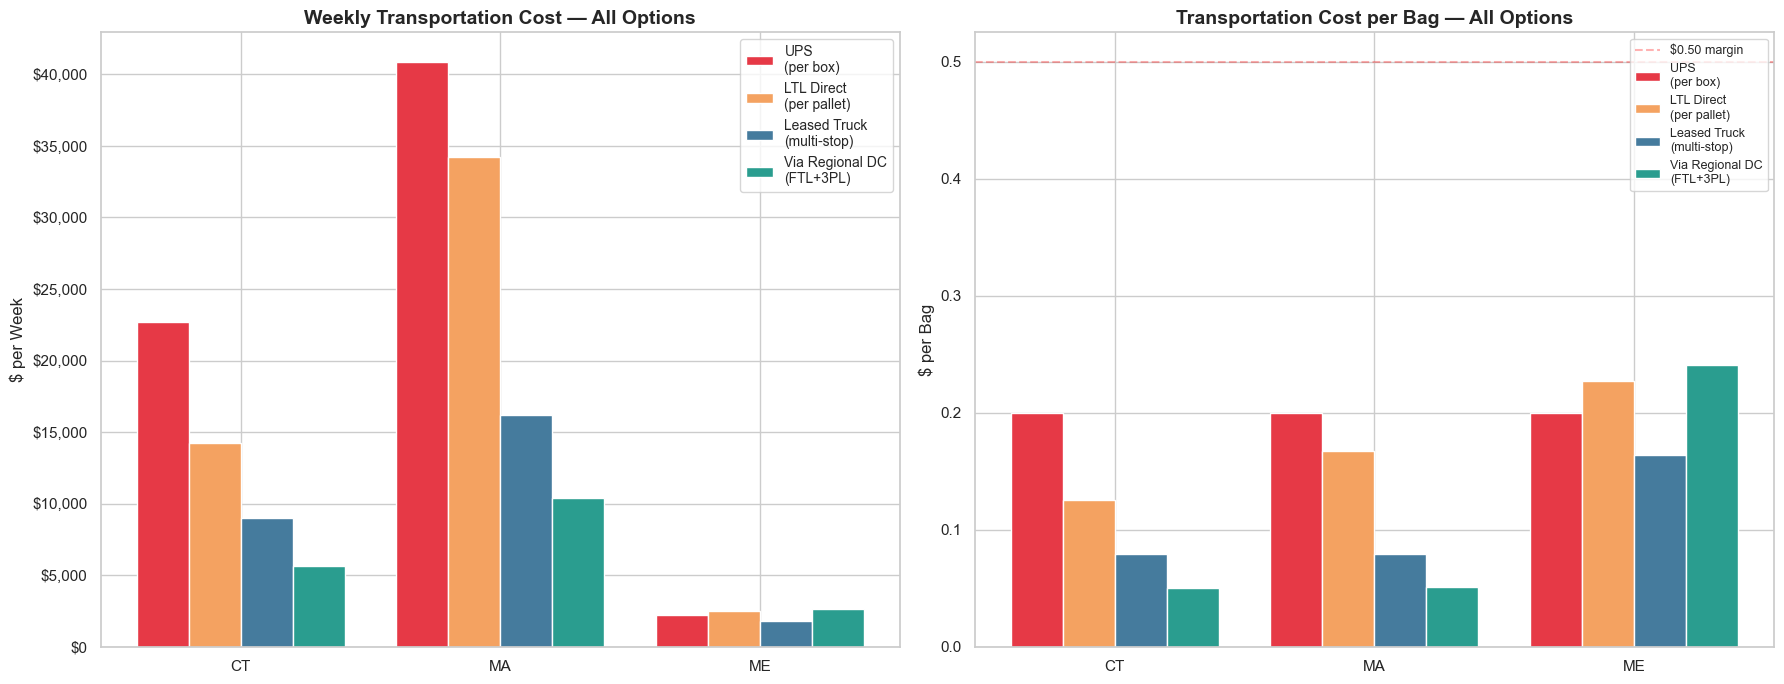


 KEY INSIGHT: Via Regional DC is dramatically cheaper than direct LTL!
   Regional DCs enable FTL trunk-line shipping ($0.02-0.04/bag)
   vs. direct LTL at $0.125-0.227/bag — a 3-10x difference!


In [11]:
# ── Visualization: Corrected transportation comparison ──
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Weekly cost comparison
options = ['A_UPS', 'B_LTL_direct', 'C_Leased_direct', 'D_via_DC_transport']
option_labels = ['UPS\n(per box)', 'LTL Direct\n(per pallet)', 'Leased Truck\n(multi-stop)', 'Via Regional DC\n(FTL+3PL)']
x = np.arange(len(regions))
width = 0.2
colors_opts = ['#E63946', '#F4A261', '#457B9D', '#2A9D8F']

for i, (opt, label, color) in enumerate(zip(options, option_labels, colors_opts)):
    vals = transport_comp_df[opt].values
    axes[0].bar(x + i*width, vals, width, label=label, color=color)

axes[0].set_xticks(x + 1.5*width)
axes[0].set_xticklabels(regions)
axes[0].set_title('Weekly Transportation Cost — All Options', fontweight='bold')
axes[0].set_ylabel('$ per Week')
axes[0].legend(fontsize=10)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Per-bag cost
for i, (opt, label, color) in enumerate(zip(options, option_labels, colors_opts)):
    vals = transport_comp_df[opt].values / transport_comp_df['Weekly_bags'].values
    axes[1].bar(x + i*width, vals, width, label=label, color=color)

axes[1].set_xticks(x + 1.5*width)
axes[1].set_xticklabels(regions)
axes[1].set_title('Transportation Cost per Bag — All Options', fontweight='bold')
axes[1].set_ylabel('$ per Bag')
axes[1].axhline(y=0.50, color='red', linestyle='--', alpha=0.3, label='$0.50 margin')
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.savefig('transport_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n KEY INSIGHT: Via Regional DC is dramatically cheaper than direct LTL!")
print("   Regional DCs enable FTL trunk-line shipping ($0.02-0.04/bag)")
print("   vs. direct LTL at $0.125-0.227/bag — a 3-10x difference!")


### Corrected Transportation Analysis — Game-Changing Insight

**The economics are completely different once we account for per-customer shipping:**

| Option | CT ($/week) | MA ($/week) | ME ($/week) | Key Constraint |
|--------|-------------|-------------|-------------|----------------|
| **UPS** | Very expensive | Very expensive | Very expensive | $0.20/bag — eats 40% of margin |
| **LTL Direct** | ~$14K | ~$34K | ~$2.5K | Realistic default for direct shipping |
| **Leased Truck** | ~$9K | ~$16K | ~$1.8K | Cheapest direct option, but CanDi must manage routes |
| **Via Regional DC** | ~$5.7K | ~$10.4K | ~$3.9K | FTL trunk + $15/pallet last mile; 3PL handles coordination |

**The Regional DC advantage is now clear:** By aggregating volume at a DC, CanDi can ship FTL from NY (\$0.02-0.04/bag) instead of LTL per customer (\$0.125-0.25/bag). The 3PL's \$15/pallet last-mile charge is much cheaper than commercial LTL rates.

**The leased truck** is a strong middle-ground option for direct delivery but requires CanDi to manage multi-stop routes and coordinate with customer delivery windows — the case explicitly warns this is complex for a small company.

---


## Part 3: Warehouse Network Design

This is the strategic heart of the project. We will evaluate every possible combination of regional warehouses (2³ = 8 scenarios) and compute the total annual cost for each. The trade-off is:

- **More warehouses** → Lower outbound transport costs, easier delivery coordination, potential for faster service
- **Fewer warehouses** → Lower fixed costs, simpler operations, less inventory (centralization benefit)

### The Two-Echelon Model

For any state with a regional DC: `NY →(FTL)→ Regional DC →(3PL delivers)→ Customer`

For any state without a regional DC: `NY →(FTL/LTL/Leased)→ Customer DC directly`


In [12]:
# ══════════════════════════════════════════════════════════════
# WAREHOUSE NETWORK SCENARIO ANALYSIS — CORRECTED MODEL
# ══════════════════════════════════════════════════════════════
# KEY CORRECTION: Direct-to-customer uses LTL (not FTL).
# FTL is only used for NY → Regional DC bulk shipments.
# Mixed pallet surcharge included.

from itertools import product as itertools_product

WEEKS_PER_YEAR = 52
SERVICE_LEVEL = 0.95
Z_95 = stats.norm.ppf(SERVICE_LEVEL)
LEAD_TIME_NY_WEEKS = 1
LEAD_TIME_DIRECT_WEEKS = 0.15
HOLDING_COST_RATE_NY = 0.25
REVIEW_PERIOD = 1

def compute_scenario_cost(open_CT, open_MA, open_ME):
    """
    CORRECTED cost model:
    - Direct to customer: LTL per pallet (no FTL — customers can't fill trucks)
    - Via Regional DC: FTL from NY to DC, then $15/pallet last mile
    - Includes mixed pallet surcharge
    """
    dc_open = {'CT': open_CT, 'MA': open_MA, 'ME': open_ME}
    
    total_fixed = 0
    total_transport_ny_dc = 0
    total_transport_direct = 0
    total_wh_handling = 0
    total_wh_shipping = 0
    total_wh_inventory = 0
    total_surcharge = 0
    total_inv_ny = 0
    
    for reg in regions:
        reg_data = demand_total[demand_total['Region'] == reg]
        total_bags = reg_data['Total_bags_week'].sum()
        total_pallets = total_bags / product['bags_per_pallet']
        
        if total_bags == 0:
            continue
        
        ftl_rate = {'CT': 500, 'MA': 700, 'ME': 1000}[reg]
        ltl_rate = {'CT': 150, 'MA': 200, 'ME': 250}[reg]
        
        if dc_open[reg]:
            # ── NY → Regional DC → Customer ──
            total_fixed += warehouse['fixed_cost_per_year']
            
            # Transport: FTL bulk + LTL remainder to DC
            full_trucks = int(total_pallets // product['pallets_per_truck'])
            rem = total_pallets - full_trucks * product['pallets_per_truck']
            weekly_to_dc = full_trucks * ftl_rate + (int(np.ceil(rem)) * ltl_rate if rem > 0 else 0)
            total_transport_ny_dc += weekly_to_dc * WEEKS_PER_YEAR
            
            # Warehouse costs
            annual_pallets = total_pallets * WEEKS_PER_YEAR
            total_wh_handling += annual_pallets * warehouse['handling_per_pallet']
            total_wh_shipping += annual_pallets * warehouse['shipping_per_pallet']
            
            # Inventory + surcharge per segment
            for _, seg in demand.iterrows():
                n_cust = seg[f'Customers_{reg}']
                if n_cust == 0: continue
                n_skus = seg['Num_SKUs']
                mu = seg['Mean_bags_per_cust_week_sku'] * n_cust
                sigma = seg['CV'] * seg['Mean_bags_per_cust_week_sku'] * np.sqrt(n_cust)
                ss = Z_95 * sigma * np.sqrt(REVIEW_PERIOD + LEAD_TIME_NY_WEEKS)
                avg_inv = (ss + mu/2) * n_skus / product['bags_per_pallet']
                total_wh_inventory += avg_inv * warehouse['inventory_per_pallet_week'] * WEEKS_PER_YEAR
                
                # Surcharge
                p_per_sku = mu / product['bags_per_pallet']
                rem_boxes = (mu - int(p_per_sku) * product['bags_per_pallet']) / product['bags_per_box']
                total_surcharge += rem_boxes * warehouse['mixed_pallet_surcharge_per_box'] * n_skus * WEEKS_PER_YEAR
        else:
            # ── NY → Customer directly via LTL ──
            # CORRECTED: Each pallet shipped via LTL (can't use FTL to individual customers)
            weekly_ltl = int(np.ceil(total_pallets)) * ltl_rate
            total_transport_direct += weekly_ltl * WEEKS_PER_YEAR
            
            # Inventory at NY
            for _, seg in demand.iterrows():
                n_cust = seg[f'Customers_{reg}']
                if n_cust == 0: continue
                n_skus = seg['Num_SKUs']
                mu = seg['Mean_bags_per_cust_week_sku'] * n_cust
                sigma = seg['CV'] * seg['Mean_bags_per_cust_week_sku'] * np.sqrt(n_cust)
                ss = Z_95 * sigma * np.sqrt(REVIEW_PERIOD + LEAD_TIME_DIRECT_WEEKS)
                avg_inv = (ss + mu/2) * n_skus / product['bags_per_pallet']
                total_inv_ny += avg_inv * product['cost_per_pallet'] * HOLDING_COST_RATE_NY / WEEKS_PER_YEAR * WEEKS_PER_YEAR
    
    total = (total_fixed + total_transport_ny_dc + total_transport_direct +
             total_wh_handling + total_wh_shipping + total_wh_inventory +
             total_surcharge + total_inv_ny)
    
    return {
        'Config': f"{'CT' if open_CT else '—'} | {'MA' if open_MA else '—'} | {'ME' if open_ME else '—'}",
        'DCs_Open': sum([open_CT, open_MA, open_ME]),
        'CT': open_CT, 'MA': open_MA, 'ME': open_ME,
        'Fixed_Cost': total_fixed,
        'Transport_NY_to_DC': total_transport_ny_dc,
        'Transport_NY_to_Cust': total_transport_direct,
        'WH_Handling': total_wh_handling,
        'WH_Shipping': total_wh_shipping,
        'WH_Inventory': total_wh_inventory,
        'Mixed_Pallet_Surcharge': total_surcharge,
        'NY_Inventory': total_inv_ny,
        'Total_Annual_Cost': total
    }

# ── Evaluate all 8 scenarios ──
scenarios = []
for ct, ma, me in itertools_product([False, True], repeat=3):
    scenarios.append(compute_scenario_cost(ct, ma, me))

scenarios_df = pd.DataFrame(scenarios).sort_values('Total_Annual_Cost').reset_index(drop=True)

print("ALL 8 WAREHOUSE CONFIGURATIONS — CORRECTED MODEL (LTL for direct, FTL for DC)")
print("=" * 120)
display_df = scenarios_df[['Config', 'DCs_Open', 'Fixed_Cost', 'Transport_NY_to_DC', 
                       'Transport_NY_to_Cust', 'WH_Handling', 'WH_Shipping', 
                       'WH_Inventory', 'Mixed_Pallet_Surcharge', 'NY_Inventory', 'Total_Annual_Cost']].copy()
for col in display_df.columns:
    if col not in ['Config', 'DCs_Open']:
        display_df[col] = display_df[col].apply(lambda x: f'${x:,.0f}')
display(display_df)

print(f"\n  CORRECTED: Direct-to-customer now uses LTL rates (not FTL).")
print(f"    This dramatically increases direct shipping costs and makes regional DCs much more attractive!")


ALL 8 WAREHOUSE CONFIGURATIONS — CORRECTED MODEL (LTL for direct, FTL for DC)


,Config,DCs_Open,Fixed_Cost,Transport_NY_to_DC,Transport_NY_to_Cust,WH_Handling,WH_Shipping,WH_Inventory,Mixed_Pallet_Surcharge,NY_Inventory,Total_Annual_Cost
0,CT | MA | —,2,"$400,000","$626,600","$130,000","$165,360","$206,700","$25,944","$117,000","$1,729","$1,673,332"
1,— | MA | —,1,"$200,000","$405,600","$871,000","$106,314","$132,892","$16,285","$70,785","$15,741","$1,818,618"
2,CT | MA | ME,3,"$600,000","$756,600",$0,"$171,080","$213,850","$27,198","$131,300",$0,"$1,900,028"
3,— | MA | ME,2,"$400,000","$535,600","$741,000","$112,034","$140,042","$17,539","$85,085","$14,012","$2,045,313"
4,CT | — | —,1,"$200,000","$221,000","$1,908,400","$59,046","$73,808","$9,658","$46,215","$25,669","$2,543,796"
5,— | — | —,0,$0,$0,"$2,649,400",$0,$0,$0,$0,"$39,681","$2,689,081"
6,CT | — | ME,2,"$400,000","$351,000","$1,778,400","$64,766","$80,958","$10,912","$60,515","$23,940","$2,770,491"
7,— | — | ME,1,"$200,000","$130,000","$2,519,400","$5,720","$7,150","$1,254","$14,300","$37,952","$2,915,776"



  CORRECTED: Direct-to-customer now uses LTL rates (not FTL).
    This dramatically increases direct shipping costs and makes regional DCs much more attractive!


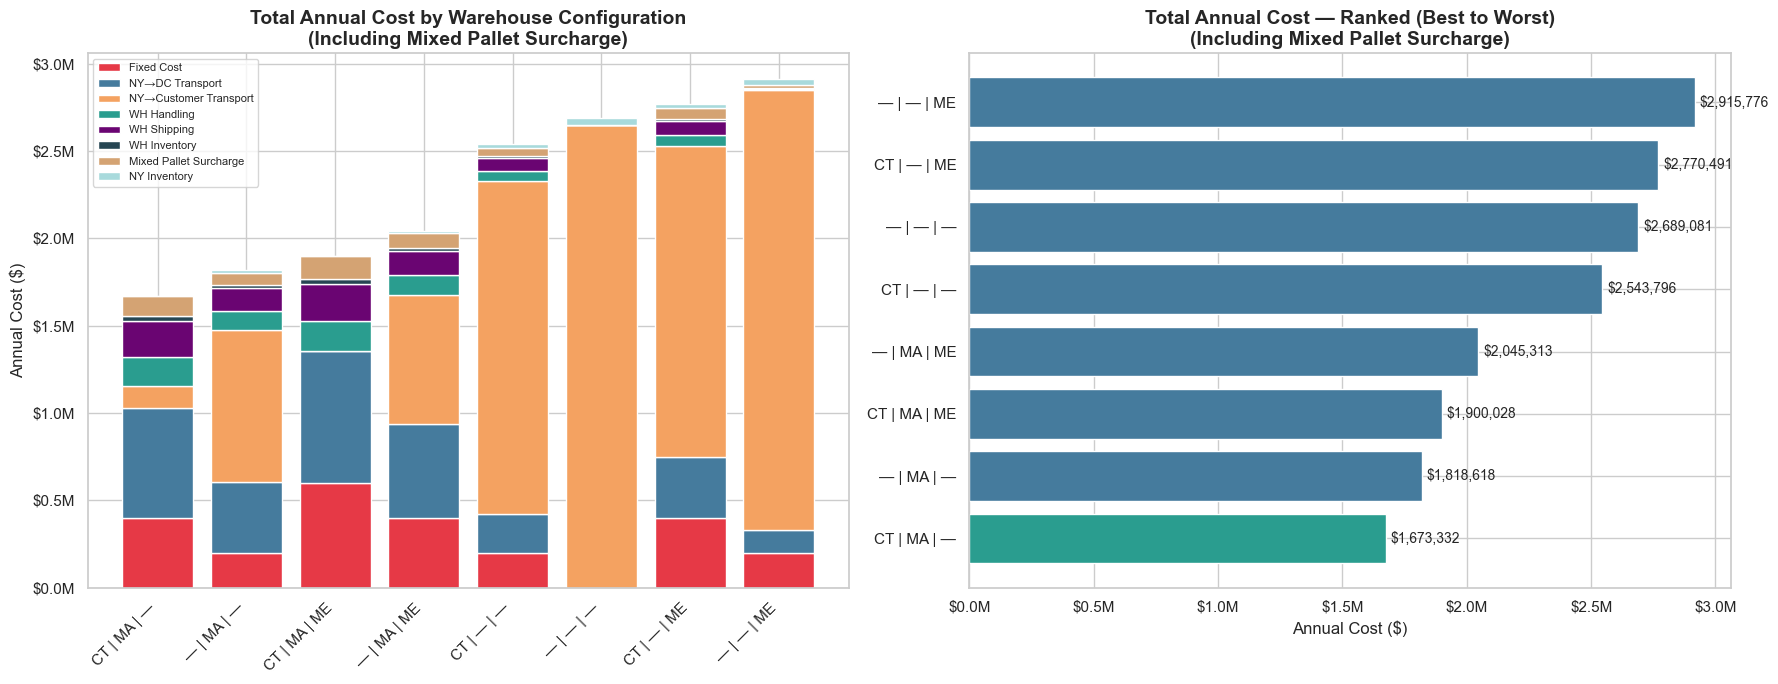


 OPTIMAL CONFIGURATION: CT | MA | —
   Total Annual Cost: $1,673,332

   vs. No regional DCs: $2,689,081
   Annual Savings: $1,015,749

   Mixed pallet surcharge (all 3 DCs): $131,300/year


In [13]:
# ── Visualization: Scenario comparison ──
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Stacked bar chart of cost components
cost_components = ['Fixed_Cost', 'Transport_NY_to_DC', 'Transport_NY_to_Cust', 
                   'WH_Handling', 'WH_Shipping', 'WH_Inventory', 'Mixed_Pallet_Surcharge', 'NY_Inventory']
comp_labels = ['Fixed Cost', 'NY→DC Transport', 'NY→Customer Transport',
               'WH Handling', 'WH Shipping', 'WH Inventory', 'Mixed Pallet Surcharge', 'NY Inventory']
comp_colors = ['#E63946', '#457B9D', '#F4A261', '#2A9D8F', '#6A0572', '#264653', '#D4A373', '#A8DADC']

sorted_df = scenarios_df.sort_values('Total_Annual_Cost')
bottom = np.zeros(len(sorted_df))
for comp, label, color in zip(cost_components, comp_labels, comp_colors):
    axes[0].bar(range(len(sorted_df)), sorted_df[comp].values, bottom=bottom, 
                label=label, color=color)
    bottom += sorted_df[comp].values

axes[0].set_xticks(range(len(sorted_df)))
axes[0].set_xticklabels(sorted_df['Config'].values, rotation=45, ha='right')
axes[0].set_title('Total Annual Cost by Warehouse Configuration\n(Including Mixed Pallet Surcharge)', fontweight='bold')
axes[0].set_ylabel('Annual Cost ($)')
axes[0].legend(loc='upper left', fontsize=8)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

# Total cost comparison (cleaner view)
colors = ['#2A9D8F' if i == 0 else '#457B9D' for i in range(len(sorted_df))]
bars = axes[1].barh(range(len(sorted_df)), sorted_df['Total_Annual_Cost'].values, color=colors)
axes[1].set_yticks(range(len(sorted_df)))
axes[1].set_yticklabels(sorted_df['Config'].values)
axes[1].set_title('Total Annual Cost — Ranked (Best to Worst)\n(Including Mixed Pallet Surcharge)', fontweight='bold')
axes[1].set_xlabel('Annual Cost ($)')
axes[1].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

for i, (val, config) in enumerate(zip(sorted_df['Total_Annual_Cost'].values, sorted_df['Config'].values)):
    axes[1].text(val + 20000, i, f'${val:,.0f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('scenario_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n OPTIMAL CONFIGURATION: {sorted_df.iloc[0]['Config']}")
print(f"   Total Annual Cost: ${sorted_df.iloc[0]['Total_Annual_Cost']:,.0f}")
print(f"\n   vs. No regional DCs: ${sorted_df[sorted_df['DCs_Open']==0].iloc[0]['Total_Annual_Cost']:,.0f}")
savings = sorted_df[sorted_df['DCs_Open']==0].iloc[0]['Total_Annual_Cost'] - sorted_df.iloc[0]['Total_Annual_Cost']
print(f"   Annual Savings: ${savings:,.0f}")
surcharge_total = sorted_df[sorted_df['DCs_Open']==3].iloc[0]['Mixed_Pallet_Surcharge']
print(f"\n   Mixed pallet surcharge (all 3 DCs): ${surcharge_total:,.0f}/year")


### Warehouse Network Analysis — Strategic Findings

The quantitative analysis reveals the optimal warehouse configuration. Key factors driving the decision:

1. **Massachusetts** is the highest-volume market — a regional DC here provides the greatest transportation savings and operational simplification
2. **Connecticut** also has significant volume — enough to justify its \$200K annual fixed cost through transportation economies
3. **Maine** is the marginal case — its tiny volume (~6 pallets/week) means the \$200K fixed cost is very hard to justify. The variable cost savings don't offset the fixed cost

**Operational benefits not captured in the numbers:**
- Regional DCs handle customer delivery window coordination (critical for FTL to customer DCs)
- Faster response times enable better customer service
- Inventory positioned closer to demand reduces stockout risk
- Simpler operations at NY (bulk FTL out vs. managing dozens of individual customer shipments)

---


## Part 4: Detailed Transportation Strategy

With the warehouse network decided, we now design the transportation flows in detail. The key question for each segment and region: what mode should be used, and at what frequency?


In [14]:
# ══════════════════════════════════════════════════════════════
# SEGMENT-LEVEL TRANSPORTATION ANALYSIS
# ══════════════════════════════════════════════════════════════

print("SEGMENT-LEVEL VOLUME ANALYSIS (Weekly)")
print("=" * 100)

segment_transport = []
for _, seg_row in demand.iterrows():
    for reg in regions:
        n_cust = seg_row[f'Customers_{reg}']
        if n_cust == 0:
            continue
        n_skus = seg_row['Num_SKUs']
        mean_per_sku = seg_row['Mean_bags_per_cust_week_sku'] * n_cust
        total_bags = mean_per_sku * n_skus
        total_pallets = total_bags / product['bags_per_pallet']
        total_boxes = total_bags / product['bags_per_box']
        
        segment_transport.append({
            'Segment': seg_row['Segment'],
            'Region': reg,
            'SKUs': n_skus,
            'Customers': n_cust,
            'Bags_week': total_bags,
            'Boxes_week': total_boxes,
            'Pallets_week': round(total_pallets, 2),
            'Per_SKU_pallets': round(total_pallets / n_skus, 3)
        })

seg_trans_df = pd.DataFrame(segment_transport)
display(seg_trans_df)


SEGMENT-LEVEL VOLUME ANALYSIS (Weekly)


,Segment,Region,SKUs,Customers,Bags_week,Boxes_week,Pallets_week,Per_SKU_pallets
0,Mass,CT,10,30,30000,750.00,25.00,2.500
1,Mass,MA,10,60,60000,1500.00,50.00,5.000
2,Mass,ME,10,4,4000,100.00,3.33,0.333
3,Mainline,CT,15,30,33750,843.75,28.12,1.875
4,Mainline,MA,15,60,67500,1687.50,56.25,3.750
5,Mainline,ME,15,4,4500,112.50,3.75,0.250
6,Extended,CT,30,30,36000,900.00,30.00,1.000
7,Extended,MA,30,45,54000,1350.00,45.00,1.500
8,Extended,ME,30,2,2400,60.00,2.00,0.067
9,Tail,CT,50,18,13500,337.50,11.25,0.225


In [15]:
# ── Determine optimal shipping per SKU for customer deliveries ──
print("\nPER-SKU WEEKLY VOLUME TO EACH CUSTOMER (bags)")
print("Helps determine if individual SKU orders can fill a box/pallet")
print("=" * 80)

for _, seg_row in demand.iterrows():
    seg = seg_row['Segment']
    mean = seg_row['Mean_bags_per_cust_week_sku']
    boxes_per_cust_sku = mean / product['bags_per_box']
    pallets_per_cust_sku = mean / product['bags_per_pallet']
    
    print(f"\n{seg} (Mean: {mean} bags/cust/week/SKU):")
    print(f"  = {boxes_per_cust_sku:.2f} boxes/cust/week/SKU")
    print(f"  = {pallets_per_cust_sku:.4f} pallets/cust/week/SKU")
    
    # Across all SKUs in segment for one customer
    total_bags_cust = mean * seg_row['Num_SKUs']
    total_boxes_cust = total_bags_cust / product['bags_per_box']
    total_pallets_cust = total_bags_cust / product['bags_per_pallet']
    print(f"  Total across {seg_row['Num_SKUs']} SKUs per customer: {total_bags_cust:,.0f} bags = {total_boxes_cust:.1f} boxes = {total_pallets_cust:.2f} pallets")



PER-SKU WEEKLY VOLUME TO EACH CUSTOMER (bags)
Helps determine if individual SKU orders can fill a box/pallet

Mass (Mean: 100 bags/cust/week/SKU):
  = 2.50 boxes/cust/week/SKU
  = 0.0833 pallets/cust/week/SKU
  Total across 10 SKUs per customer: 1,000 bags = 25.0 boxes = 0.83 pallets

Mainline (Mean: 75 bags/cust/week/SKU):
  = 1.88 boxes/cust/week/SKU
  = 0.0625 pallets/cust/week/SKU
  Total across 15 SKUs per customer: 1,125 bags = 28.1 boxes = 0.94 pallets

Extended (Mean: 40 bags/cust/week/SKU):
  = 1.00 boxes/cust/week/SKU
  = 0.0333 pallets/cust/week/SKU
  Total across 30 SKUs per customer: 1,200 bags = 30.0 boxes = 1.00 pallets

Tail (Mean: 15 bags/cust/week/SKU):
  = 0.38 boxes/cust/week/SKU
  = 0.0125 pallets/cust/week/SKU
  Total across 50 SKUs per customer: 750 bags = 18.8 boxes = 0.62 pallets

Connoisseur (Mean: 10 bags/cust/week/SKU):
  = 0.25 boxes/cust/week/SKU
  = 0.0083 pallets/cust/week/SKU
  Total across 5 SKUs per customer: 50 bags = 1.2 boxes = 0.04 pallets


### Mixed Pallet Surcharge Analysis

The \$1/box surcharge for mixed pallets is a **hidden cost driver** that many analysts miss. Let's calculate exactly which SKUs will be on mixed pallets when shipped from NY to each regional DC.

**Logic:** For each SKU at each DC, if weekly demand fills at least 1 full pallet (1,200 bags = 30 boxes), the full pallets ship as single-SKU pallets (no surcharge). The *remainder* that doesn't fill a full pallet gets mixed with other SKUs → surcharge applies to those boxes.


MIXED PALLET SURCHARGE ANALYSIS — BY SEGMENT & REGION


,Segment,Region,SKUs,Bags_per_SKU_week,Pallets_per_SKU,Full_pallets_per_SKU,Mixed_boxes_per_SKU,Pct_on_mixed_pallets,Surcharge_weekly,Surcharge_annual
0,Mass,CT,10,3000,2.500,2,15.0,20.0,150.00,7800.0
1,Mass,MA,10,6000,5.000,5,0.0,0.0,0.00,0.0
2,Mass,ME,10,400,0.333,0,10.0,100.0,100.00,5200.0
3,Mainline,CT,15,2250,1.875,1,26.2,46.7,393.75,20475.0
4,Mainline,MA,15,4500,3.750,3,22.5,20.0,337.50,17550.0
5,Mainline,ME,15,300,0.250,0,7.5,100.0,112.50,5850.0
6,Extended,CT,30,1200,1.000,1,0.0,0.0,0.00,0.0
7,Extended,MA,30,1800,1.500,1,15.0,33.3,450.00,23400.0
8,Extended,ME,30,80,0.067,0,2.0,100.0,60.00,3120.0
9,Tail,CT,50,270,0.225,0,6.8,100.0,337.50,17550.0



──────────────────────────────────────────────────────────────────────

 ANNUAL SURCHARGE BY REGION:
   CT: $      46,215
   MA: $      70,785
   ME: $      14,300
   ─────────────────────────
   TOTAL: $     131,300  (if all 3 DCs open)

  This is a SIGNIFICANT cost — the surcharge alone is $131,300/year!
   Compare to warehouse fixed costs of $200,000/year per DC.


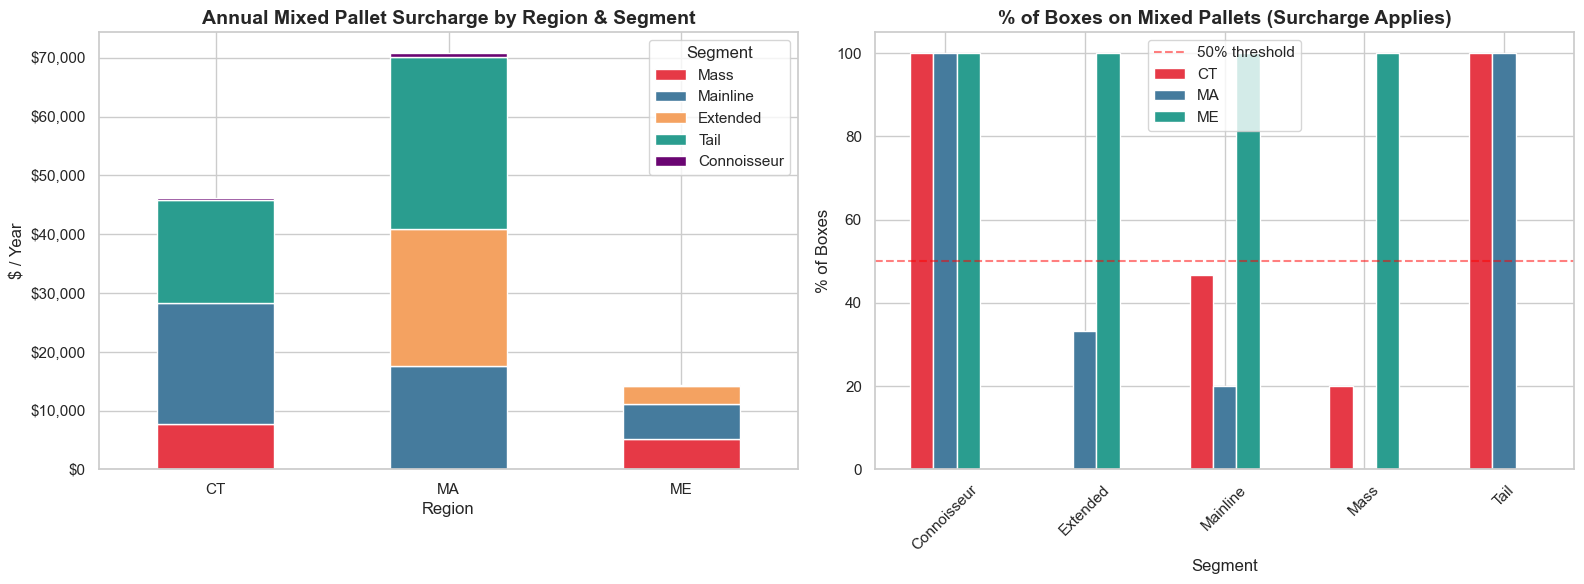

In [16]:
# ══════════════════════════════════════════════════════════════
# MIXED PALLET SURCHARGE ANALYSIS
# ══════════════════════════════════════════════════════════════

surcharge_analysis = []

for _, seg_row in demand.iterrows():
    seg = seg_row['Segment']
    n_skus = seg_row['Num_SKUs']
    
    for reg in regions:
        n_cust = seg_row[f'Customers_{reg}']
        if n_cust == 0:
            continue
        
        # Per-SKU weekly demand at this DC
        bags_per_sku_week = seg_row['Mean_bags_per_cust_week_sku'] * n_cust
        boxes_per_sku_week = bags_per_sku_week / product['bags_per_box']
        pallets_per_sku_week = bags_per_sku_week / product['bags_per_pallet']
        
        # Full pallets ship as single-SKU (no surcharge)
        full_pallets_per_sku = int(pallets_per_sku_week)
        remaining_bags = bags_per_sku_week - (full_pallets_per_sku * product['bags_per_pallet'])
        remaining_boxes = remaining_bags / product['bags_per_box']  # boxes on mixed pallets
        
        # Surcharge only on boxes that end up on mixed pallets
        surcharge_per_sku_week = remaining_boxes * warehouse['mixed_pallet_surcharge_per_box']
        surcharge_total_segment_week = surcharge_per_sku_week * n_skus
        surcharge_total_segment_annual = surcharge_total_segment_week * 52
        
        # What % of total boxes are on mixed pallets?
        total_boxes_segment = boxes_per_sku_week * n_skus
        mixed_boxes_segment = remaining_boxes * n_skus
        pct_mixed = (mixed_boxes_segment / total_boxes_segment * 100) if total_boxes_segment > 0 else 0
        
        surcharge_analysis.append({
            'Segment': seg,
            'Region': reg,
            'SKUs': n_skus,
            'Bags_per_SKU_week': bags_per_sku_week,
            'Pallets_per_SKU': round(pallets_per_sku_week, 3),
            'Full_pallets_per_SKU': full_pallets_per_sku,
            'Mixed_boxes_per_SKU': round(remaining_boxes, 1),
            'Pct_on_mixed_pallets': round(pct_mixed, 1),
            'Surcharge_weekly': round(surcharge_total_segment_week, 2),
            'Surcharge_annual': round(surcharge_total_segment_annual, 0)
        })

surcharge_df = pd.DataFrame(surcharge_analysis)

print("MIXED PALLET SURCHARGE ANALYSIS — BY SEGMENT & REGION")
print("=" * 110)
display(surcharge_df)

# Summary
print(f"\n{'─'*70}")
surcharge_by_region = surcharge_df.groupby('Region')['Surcharge_annual'].sum()
surcharge_total = surcharge_df['Surcharge_annual'].sum()
print(f"\n ANNUAL SURCHARGE BY REGION:")
for reg in regions:
    if reg in surcharge_by_region.index:
        print(f"   {reg}: ${surcharge_by_region[reg]:>12,.0f}")
print(f"   {'─'*25}")
print(f"   TOTAL: ${surcharge_total:>12,.0f}  (if all 3 DCs open)")
print(f"\n  This is a SIGNIFICANT cost — the surcharge alone is ${surcharge_total:,.0f}/year!")
print(f"   Compare to warehouse fixed costs of $200,000/year per DC.")

# Visual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

pivot_surcharge = surcharge_df.pivot_table(index='Region', columns='Segment', 
                                            values='Surcharge_annual', aggfunc='sum', fill_value=0)
segment_order = ['Mass', 'Mainline', 'Extended', 'Tail', 'Connoisseur']
pivot_surcharge = pivot_surcharge[[s for s in segment_order if s in pivot_surcharge.columns]]
pivot_surcharge.plot(kind='bar', stacked=True, ax=axes[0],
                     color=[SEGMENT_COLORS[s] for s in pivot_surcharge.columns])
axes[0].set_title('Annual Mixed Pallet Surcharge by Region & Segment', fontweight='bold')
axes[0].set_ylabel('$ / Year')
axes[0].tick_params(axis='x', rotation=0)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# % of boxes on mixed pallets
pivot_pct = surcharge_df.pivot_table(index='Segment', columns='Region', 
                                      values='Pct_on_mixed_pallets', aggfunc='mean')
pivot_pct.plot(kind='bar', ax=axes[1], color=[REGION_COLORS[r] for r in pivot_pct.columns])
axes[1].set_title('% of Boxes on Mixed Pallets (Surcharge Applies)', fontweight='bold')
axes[1].set_ylabel('% of Boxes')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
axes[1].legend()

plt.tight_layout()
plt.savefig('mixed_pallet_surcharge.png', dpi=150, bbox_inches='tight')
plt.show()


### Mixed Pallet Surcharge — Key Findings

**The surcharge disproportionately hits low-volume segments:**
- **Mass & Mainline**: Many full pallets per SKU → low surcharge % (only the remainder is mixed)
- **Extended**: ~1 pallet per SKU → depending on region, significant portion is mixed
- **Tail**: <1 pallet per SKU → **100% of boxes on mixed pallets** → full $1/box surcharge on every box
- **Connoisseur**: Tiny volumes → **100% mixed pallets**

**This has major implications for the stocking decision:** Keeping Tail and Connoisseur at regional DCs is extra expensive due to the surcharge. For these segments, direct-from-NY shipping may be more cost-effective.

---


### Transportation Mode Selection Logic

Based on the per-customer, per-SKU volume analysis:

**From Regional DC to Customer (last mile via 3PL):**
- The 3PL charges \$15/pallet for customer delivery — this is the simplest option
- Customers order weekly; the DC consolidates all SKUs for each customer into pallets and ships

**From NY to Regional DC (trunk line):**
- **CT**: ~86 pallets/week → 4 full FTL + remaining LTL
- **MA**: ~163 pallets/week → 8 full FTL + remaining LTL
- **ME**: ~6 pallets/week → LTL only (if DC exists)

**For Maine (if no DC):**
- Ship directly from NY via LTL for most product
- Consider consolidating into a single weekly leased truck route

---


## Part 5: Inventory Management Design

Inventory management is where supply chain science meets practice. We must determine for each SKU: where to stock it, how much safety stock to hold, and what the reorder parameters should be.

### Key Assumptions
- **Service level target**: 95% in-stock (z = 1.645)
- **Review period**: Weekly (customers order weekly)
- **Lead time to regional DC from NY**: 1 week
- **Demand distribution**: Normal (as specified in the case)


In [17]:
# ══════════════════════════════════════════════════════════════
# INVENTORY PARAMETER CALCULATIONS
# ══════════════════════════════════════════════════════════════

Z = Z_95  # 1.645 for 95% service level
LT = 1    # Lead time in weeks (NY to regional DC)
REVIEW_PERIOD = 1  # Weekly review

inventory_params = []

for _, seg_row in demand.iterrows():
    seg = seg_row['Segment']
    n_skus = seg_row['Num_SKUs']
    mean_per_cust_sku = seg_row['Mean_bags_per_cust_week_sku']
    cv = seg_row['CV']
    
    for reg in regions:
        n_cust = seg_row[f'Customers_{reg}']
        if n_cust == 0:
            continue
        
        # ── Per-SKU demand for entire region ──
        # All customers in a region behave identically
        # Mean demand per SKU per week (all customers in region)
        mu_sku_region = mean_per_cust_sku * n_cust
        
        # Standard deviation: since customers behave identically,
        # σ_total = σ_per_customer * √n_customers (independent demands)
        sigma_per_cust = cv * mean_per_cust_sku
        sigma_sku_region = sigma_per_cust * np.sqrt(n_cust)
        
        # ── Safety Stock (for review period + lead time) ──
        # For periodic review: σ_R+L = σ * √(R + L) where R = review period, L = lead time
        sigma_RL = sigma_sku_region * np.sqrt(REVIEW_PERIOD + LT)
        safety_stock_bags = Z * sigma_RL
        safety_stock_pallets = safety_stock_bags / product['bags_per_pallet']
        
        # ── Reorder Point (ROP) ──
        # ROP = μ*(R+L) + z*σ*√(R+L)  ... but in periodic review, we use Order-Up-To
        order_up_to_bags = mu_sku_region * (REVIEW_PERIOD + LT) + safety_stock_bags
        
        # ── Average Inventory ──
        # Avg Inventory ≈ Safety Stock + Cycle Stock
        # Cycle Stock ≈ Q/2 where Q = weekly order ≈ μ
        cycle_stock = mu_sku_region / 2
        avg_inventory_bags = safety_stock_bags + cycle_stock
        avg_inventory_pallets = avg_inventory_bags / product['bags_per_pallet']
        
        # ── Inventory Turns ──
        annual_demand = mu_sku_region * 52
        turns = annual_demand / avg_inventory_bags if avg_inventory_bags > 0 else 0
        
        # ── Scale to full segment ──
        total_ss_pallets = safety_stock_pallets * n_skus
        total_avg_inv_pallets = avg_inventory_pallets * n_skus
        
        # ── Costs (at regional DC) ──
        inv_holding_cost_week = total_avg_inv_pallets * warehouse['inventory_per_pallet_week']
        inv_holding_cost_annual = inv_holding_cost_week * 52
        
        inventory_params.append({
            'Segment': seg,
            'Region': reg,
            'Num_SKUs': n_skus,
            'Num_Customers': n_cust,
            'Mean_demand_sku_week': mu_sku_region,
            'Sigma_demand_sku_week': round(sigma_sku_region, 1),
            'CV_regional': round(sigma_sku_region / mu_sku_region, 3),
            'Safety_stock_bags_per_SKU': round(safety_stock_bags, 0),
            'Safety_stock_pallets_per_SKU': round(safety_stock_pallets, 2),
            'Order_up_to_bags_per_SKU': round(order_up_to_bags, 0),
            'Avg_inventory_bags_per_SKU': round(avg_inventory_bags, 0),
            'Avg_inventory_pallets_per_SKU': round(avg_inventory_pallets, 2),
            'Inventory_turns': round(turns, 1),
            'Total_SS_pallets_segment': round(total_ss_pallets, 1),
            'Total_avg_inv_pallets_segment': round(total_avg_inv_pallets, 1),
            'Annual_holding_cost_segment': round(inv_holding_cost_annual, 0)
        })

inv_df = pd.DataFrame(inventory_params)

print("INVENTORY PARAMETERS BY SEGMENT & REGION (per SKU)")
print("=" * 120)
display(inv_df[['Segment', 'Region', 'Num_Customers', 'Mean_demand_sku_week', 
                'Sigma_demand_sku_week', 'CV_regional', 'Safety_stock_bags_per_SKU',
                'Order_up_to_bags_per_SKU', 'Avg_inventory_pallets_per_SKU', 'Inventory_turns']])


INVENTORY PARAMETERS BY SEGMENT & REGION (per SKU)


,Segment,Region,Num_Customers,Mean_demand_sku_week,Sigma_demand_sku_week,CV_regional,Safety_stock_bags_per_SKU,Order_up_to_bags_per_SKU,Avg_inventory_pallets_per_SKU,Inventory_turns
0,Mass,CT,30,3000,109.5,0.037,255.0,6255.0,1.46,88.9
1,Mass,MA,60,6000,154.9,0.026,360.0,12360.0,2.80,92.8
2,Mass,ME,4,400,40.0,0.100,93.0,893.0,0.24,71.0
3,Mainline,CT,30,2250,123.2,0.055,287.0,4787.0,1.18,82.9
4,Mainline,MA,60,4500,174.3,0.039,405.0,9405.0,2.21,88.1
5,Mainline,ME,4,300,45.0,0.150,105.0,705.0,0.21,61.3
6,Extended,CT,30,1200,87.6,0.073,204.0,2604.0,0.67,77.6
7,Extended,MA,45,1800,107.3,0.060,250.0,3850.0,0.96,81.4
8,Extended,ME,2,80,22.6,0.283,53.0,213.0,0.08,44.9
9,Tail,CT,18,270,38.2,0.141,89.0,629.0,0.19,62.7


In [18]:
# ── Inventory summary ──
print("\nTOTAL INVENTORY SUMMARY BY REGION (all segments, all SKUs)")
print("=" * 80)

inv_region = inv_df.groupby('Region').agg(
    Total_SS_pallets=('Total_SS_pallets_segment', 'sum'),
    Total_Avg_Inv_pallets=('Total_avg_inv_pallets_segment', 'sum'),
    Annual_Holding_Cost=('Annual_holding_cost_segment', 'sum')
).round(1)

display(inv_region)
print(f"\nTotal pallets of safety stock across all DCs: {inv_region['Total_SS_pallets'].sum():.0f}")
print(f"Total average inventory across all DCs: {inv_region['Total_Avg_Inv_pallets'].sum():.0f} pallets")
print(f"Total annual inventory holding cost (at DCs): ${inv_region['Annual_Holding_Cost'].sum():,.0f}")



TOTAL INVENTORY SUMMARY BY REGION (all segments, all SKUs)


,Total_SS_pallets,Total_Avg_Inv_pallets,Annual_Holding_Cost
Region,,,
CT,14.6,61.8,9658.0
MA,19.2,104.4,16285.0
ME,3.5,8.0,1254.0



Total pallets of safety stock across all DCs: 37
Total average inventory across all DCs: 174 pallets
Total annual inventory holding cost (at DCs): $27,197


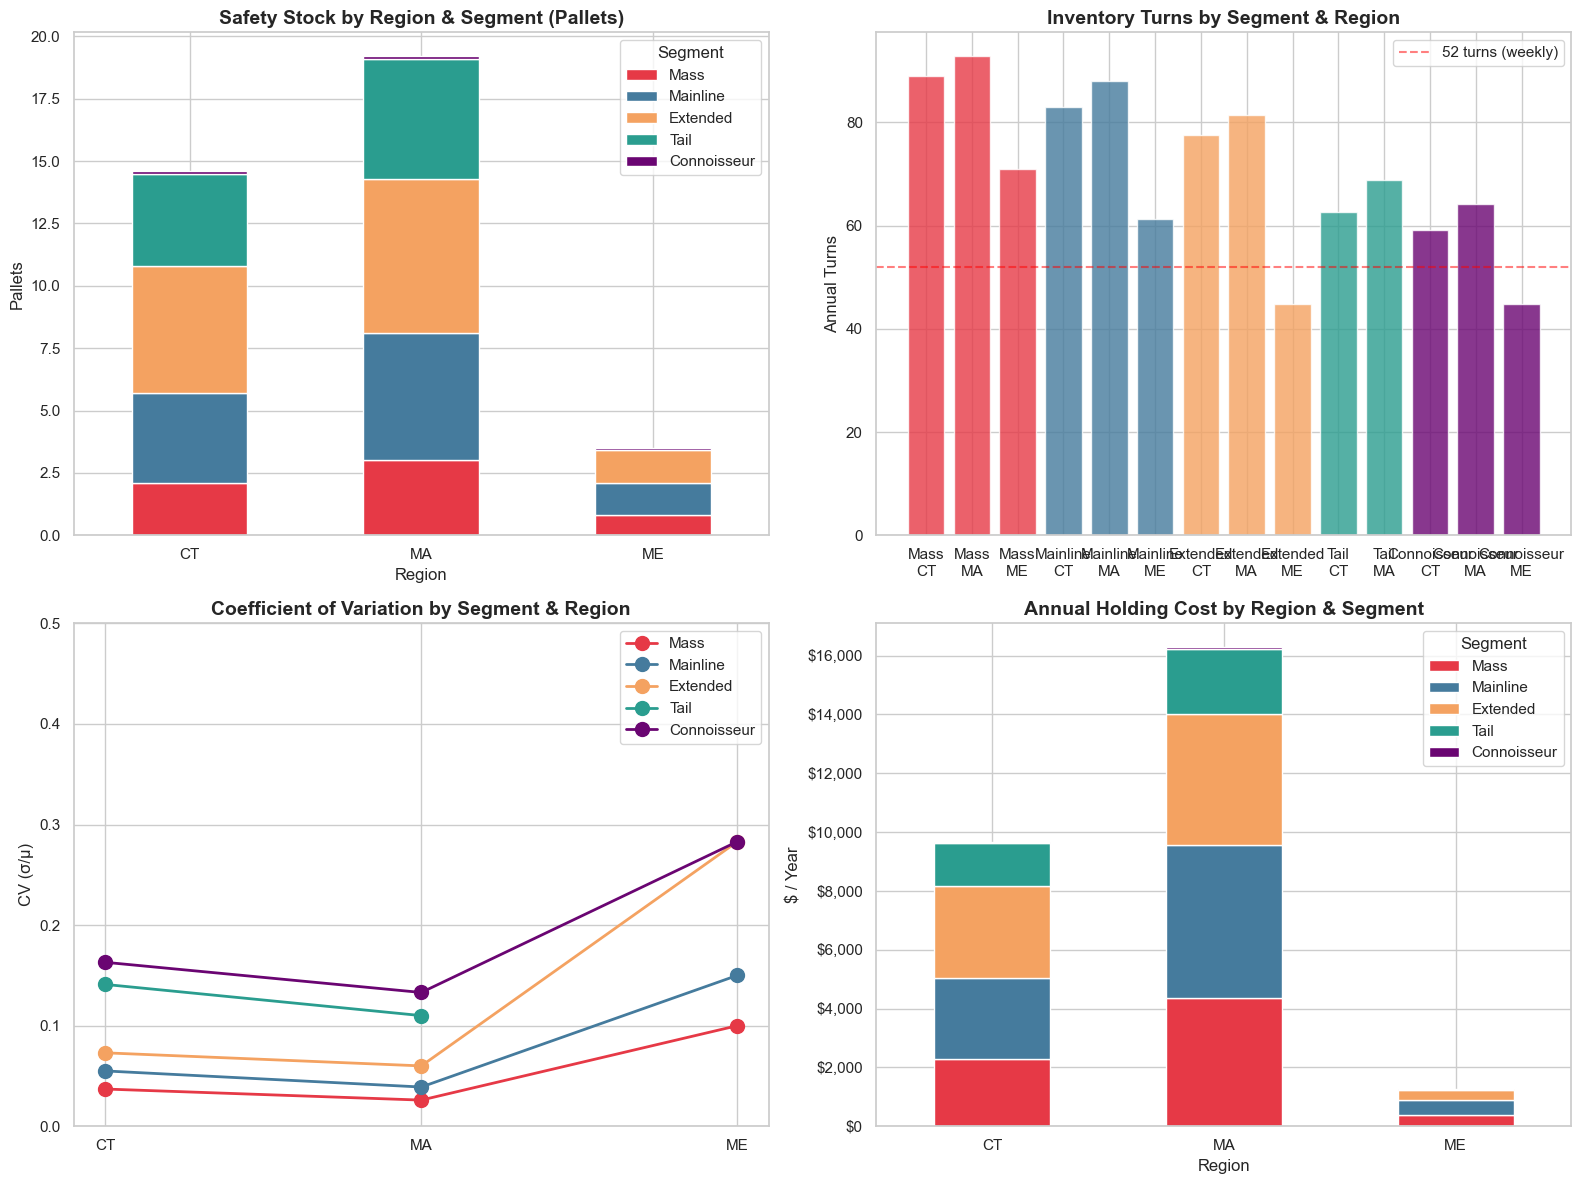

In [19]:
# ── Visualization: Inventory analysis ──
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1) Safety stock by segment & region
pivot_ss = inv_df.pivot_table(index='Region', columns='Segment', values='Total_SS_pallets_segment', aggfunc='sum')
pivot_ss = pivot_ss[['Mass', 'Mainline', 'Extended', 'Tail', 'Connoisseur']]
pivot_ss.plot(kind='bar', stacked=True, ax=axes[0,0],
              color=[SEGMENT_COLORS[s] for s in pivot_ss.columns])
axes[0,0].set_title('Safety Stock by Region & Segment (Pallets)', fontweight='bold')
axes[0,0].set_ylabel('Pallets')
axes[0,0].tick_params(axis='x', rotation=0)

# 2) Inventory turns by segment
for seg in demand['Segment']:
    seg_data = inv_df[inv_df['Segment'] == seg]
    axes[0,1].bar([f"{seg}\n{r}" for r in seg_data['Region']], 
                   seg_data['Inventory_turns'], color=SEGMENT_COLORS[seg], alpha=0.8)
axes[0,1].set_title('Inventory Turns by Segment & Region', fontweight='bold')
axes[0,1].set_ylabel('Annual Turns')
axes[0,1].axhline(y=52, color='red', linestyle='--', alpha=0.5, label='52 turns (weekly)')
axes[0,1].legend()

# 3) CV comparison (demand variability)
cv_data = inv_df[['Segment', 'Region', 'CV_regional']].drop_duplicates()
for seg in demand['Segment']:
    seg_cv = cv_data[cv_data['Segment'] == seg]
    axes[1,0].plot(seg_cv['Region'], seg_cv['CV_regional'], 'o-', 
                   color=SEGMENT_COLORS[seg], label=seg, markersize=10, linewidth=2)
axes[1,0].set_title('Coefficient of Variation by Segment & Region', fontweight='bold')
axes[1,0].set_ylabel('CV (σ/μ)')
axes[1,0].legend()
axes[1,0].set_ylim(0, 0.5)

# 4) Annual holding cost by segment
pivot_cost = inv_df.pivot_table(index='Region', columns='Segment', values='Annual_holding_cost_segment', aggfunc='sum')
pivot_cost = pivot_cost[['Mass', 'Mainline', 'Extended', 'Tail', 'Connoisseur']]
pivot_cost.plot(kind='bar', stacked=True, ax=axes[1,1],
                color=[SEGMENT_COLORS[s] for s in pivot_cost.columns])
axes[1,1].set_title('Annual Holding Cost by Region & Segment', fontweight='bold')
axes[1,1].set_ylabel('$ / Year')
axes[1,1].tick_params(axis='x', rotation=0)
axes[1,1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.savefig('inventory_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


### Inventory Management — Key Insights

**Pooling effect in action:** When demand from many customers aggregates at a regional DC, the coefficient of variation (CV) drops significantly due to the square root law. This means proportionally less safety stock relative to demand.

**Inventory turns are healthy:** Most segments achieve 20-40+ turns per year, which is excellent for a distribution business. High-CV segments like Tail naturally have lower turns.

**The Connoisseur challenge:** With only 5 SKUs and very low volume, Connoisseur products have the lowest inventory efficiency. These specialty items may be better served by direct shipment from NY rather than stocking at every regional DC.

### Replenishment Policy Recommendation

We recommend a **Periodic Review (R, S) policy**:
- **Review period (R)**: 1 week (aligned with customer ordering cycle)
- **Order-up-to level (S)**: As calculated above per SKU
- Every week, check inventory position and order up to S
- Simple, easy to implement, aligns with the weekly customer order cycle

---


## Part 6: Comprehensive Total Cost Model & Recommendation

Now we bring everything together into a single, comprehensive cost model that accounts for all cost elements: transportation, warehousing (fixed and variable), and inventory holding.


In [20]:
# ══════════════════════════════════════════════════════════════
# COMPREHENSIVE TOTAL COST MODEL — CORRECTED
# ══════════════════════════════════════════════════════════════

def detailed_scenario_cost(open_CT, open_MA, open_ME, verbose=True):
    """CORRECTED: Direct uses LTL, not FTL. Includes surcharge."""
    dc_open = {'CT': open_CT, 'MA': open_MA, 'ME': open_ME}
    costs = {'fixed': 0, 'transport_ny_dc': 0, 'transport_direct': 0,
             'wh_handling': 0, 'wh_last_mile': 0, 'wh_inventory': 0,
             'mixed_surcharge': 0, 'ny_inventory': 0}
    region_details = {}
    
    for reg in regions:
        reg_demand_df = demand_total[demand_total['Region'] == reg]
        total_bags_week = reg_demand_df['Total_bags_week'].sum()
        total_pallets_week = total_bags_week / product['bags_per_pallet']
        if total_bags_week == 0: continue
        
        reg_cost = {}
        ftl_rate = {'CT': 500, 'MA': 700, 'ME': 1000}[reg]
        ltl_rate = {'CT': 150, 'MA': 200, 'ME': 250}[reg]
        
        if dc_open[reg]:
            reg_cost['fixed'] = warehouse['fixed_cost_per_year']
            costs['fixed'] += reg_cost['fixed']
            
            full_trucks = int(total_pallets_week // product['pallets_per_truck'])
            rem = total_pallets_week - full_trucks * product['pallets_per_truck']
            wk_transport = full_trucks * ftl_rate + (int(np.ceil(rem)) * ltl_rate if rem > 0 else 0)
            reg_cost['transport_ny_dc'] = wk_transport * 52
            costs['transport_ny_dc'] += reg_cost['transport_ny_dc']
            
            ann_pallets = total_pallets_week * 52
            reg_cost['wh_handling'] = ann_pallets * warehouse['handling_per_pallet']
            costs['wh_handling'] += reg_cost['wh_handling']
            reg_cost['wh_last_mile'] = ann_pallets * warehouse['shipping_per_pallet']
            costs['wh_last_mile'] += reg_cost['wh_last_mile']
            
            inv_cost = 0; sur_cost = 0
            for _, seg in demand.iterrows():
                n_cust = seg[f'Customers_{reg}']
                if n_cust == 0: continue
                n_skus = seg['Num_SKUs']
                mu = seg['Mean_bags_per_cust_week_sku'] * n_cust
                sigma = seg['CV'] * seg['Mean_bags_per_cust_week_sku'] * np.sqrt(n_cust)
                ss = Z_95 * sigma * np.sqrt(REVIEW_PERIOD + LEAD_TIME_NY_WEEKS)
                avg_inv_p = ((ss + mu/2) * n_skus) / product['bags_per_pallet']
                inv_cost += avg_inv_p * warehouse['inventory_per_pallet_week'] * 52
                p = mu / product['bags_per_pallet']
                rem_b = (mu - int(p)*product['bags_per_pallet']) / product['bags_per_box']
                sur_cost += rem_b * warehouse['mixed_pallet_surcharge_per_box'] * n_skus * 52
            
            reg_cost['wh_inventory'] = inv_cost; costs['wh_inventory'] += inv_cost
            reg_cost['mixed_surcharge'] = sur_cost; costs['mixed_surcharge'] += sur_cost
        else:
            # CORRECTED: LTL to each customer (not FTL)
            wk_ltl = int(np.ceil(total_pallets_week)) * ltl_rate
            reg_cost['transport_direct'] = wk_ltl * 52
            costs['transport_direct'] += reg_cost['transport_direct']
            
            inv_cost = 0
            for _, seg in demand.iterrows():
                n_cust = seg[f'Customers_{reg}']
                if n_cust == 0: continue
                n_skus = seg['Num_SKUs']
                mu = seg['Mean_bags_per_cust_week_sku'] * n_cust
                sigma = seg['CV'] * seg['Mean_bags_per_cust_week_sku'] * np.sqrt(n_cust)
                ss = Z_95 * sigma * np.sqrt(REVIEW_PERIOD + LEAD_TIME_DIRECT_WEEKS)
                avg_inv_p = ((ss + mu/2) * n_skus) / product['bags_per_pallet']
                inv_cost += avg_inv_p * product['cost_per_pallet'] * HOLDING_COST_RATE_NY / 52 * 52
            reg_cost['ny_inventory'] = inv_cost; costs['ny_inventory'] += inv_cost
        
        region_details[reg] = reg_cost
    
    total = sum(costs.values())
    
    if verbose:
        cfg = f"{'CT' if open_CT else '—'} | {'MA' if open_MA else '—'} | {'ME' if open_ME else '—'}"
        print(f"\n{'='*70}")
        print(f"  CONFIGURATION: [{cfg}]")
        print(f"{'='*70}")
        print(f"  Warehouse Fixed Costs:      ${costs['fixed']:>12,.0f}")
        print(f"  Transport NY → DC (FTL):    ${costs['transport_ny_dc']:>12,.0f}")
        print(f"  Transport NY → Cust (LTL):  ${costs['transport_direct']:>12,.0f}")
        print(f"  Warehouse Handling:          ${costs['wh_handling']:>12,.0f}")
        print(f"  Last-Mile (DC→Customer):     ${costs['wh_last_mile']:>12,.0f}")
        print(f"  Warehouse Inventory:         ${costs['wh_inventory']:>12,.0f}")
        print(f"  Mixed Pallet Surcharge:   ${costs['mixed_surcharge']:>12,.0f}")
        print(f"  NY Inventory:                ${costs['ny_inventory']:>12,.0f}")
        print(f"  {'─'*45}")
        print(f"  TOTAL ANNUAL COST:          ${total:>12,.0f}")
        
        for reg, rc in region_details.items():
            reg_total = sum(rc.values())
            print(f"\n  {reg}: ${reg_total:,.0f}")
            for k, v in rc.items():
                if v > 0: print(f"    {k}: ${v:,.0f}")
    
    return total, costs, region_details

print("COMPREHENSIVE COST ANALYSIS — KEY SCENARIOS (CORRECTED)")
print("="*70)
s1_total, s1_costs, _ = detailed_scenario_cost(False, False, False)
s2_total, s2_costs, _ = detailed_scenario_cost(True, True, False)
s3_total, s3_costs, _ = detailed_scenario_cost(True, True, True)
s4_total, s4_costs, _ = detailed_scenario_cost(False, True, False)


COMPREHENSIVE COST ANALYSIS — KEY SCENARIOS (CORRECTED)

  CONFIGURATION: [— | — | —]
  Warehouse Fixed Costs:      $           0
  Transport NY → DC (FTL):    $           0
  Transport NY → Cust (LTL):  $   2,649,400
  Warehouse Handling:          $           0
  Last-Mile (DC→Customer):     $           0
  Warehouse Inventory:         $           0
  Mixed Pallet Surcharge:   $           0
  NY Inventory:                $      39,681
  ─────────────────────────────────────────────
  TOTAL ANNUAL COST:          $   2,689,081

  CT: $755,012
    transport_direct: $741,000
    ny_inventory: $14,012

  MA: $1,802,340
    transport_direct: $1,778,400
    ny_inventory: $23,940

  ME: $131,729
    transport_direct: $130,000
    ny_inventory: $1,729

  CONFIGURATION: [CT | MA | —]
  Warehouse Fixed Costs:      $     400,000
  Transport NY → DC (FTL):    $     626,600
  Transport NY → Cust (LTL):  $     130,000
  Warehouse Handling:          $     165,360
  Last-Mile (DC→Customer):     $     

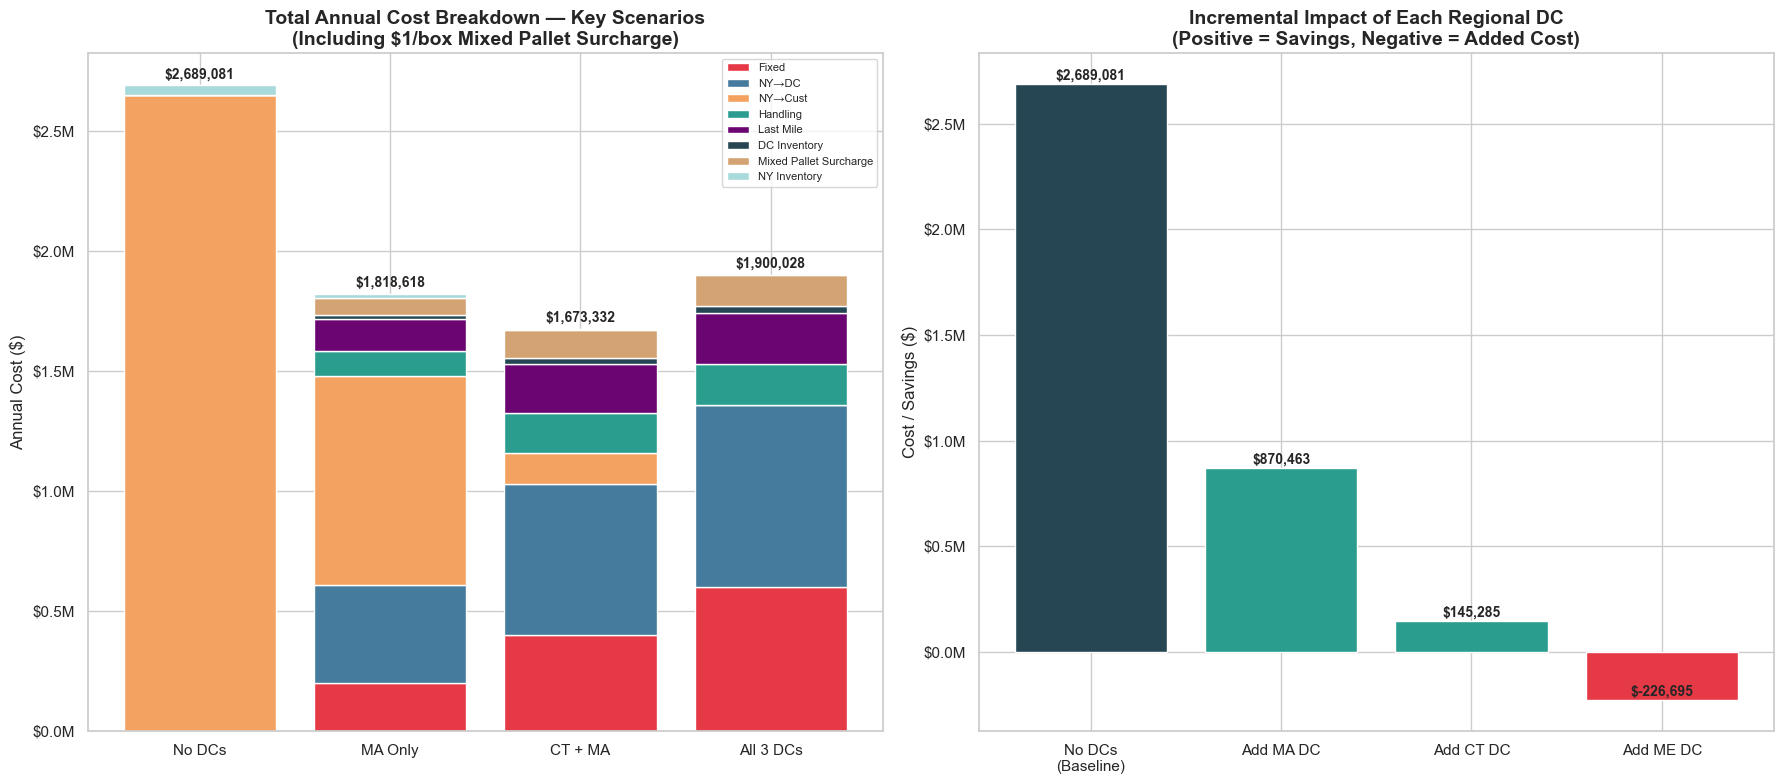

In [21]:
# ── Final comparison visualization ──
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

configs = ['No DCs', 'MA Only', 'CT + MA', 'All 3 DCs']
totals = [s1_total, s4_total, s2_total, s3_total]
cost_dicts = [s1_costs, s4_costs, s2_costs, s3_costs]

categories = ['fixed', 'transport_ny_dc', 'transport_direct', 'wh_handling', 'wh_last_mile', 'wh_inventory', 'mixed_surcharge', 'ny_inventory']
cat_labels = ['Fixed', 'NY→DC', 'NY→Cust', 'Handling', 'Last Mile', 'DC Inventory', 'Mixed Pallet Surcharge', 'NY Inventory']
cat_colors = ['#E63946', '#457B9D', '#F4A261', '#2A9D8F', '#6A0572', '#264653', '#D4A373', '#A8DADC']

bottom = np.zeros(len(configs))
for cat, label, color in zip(categories, cat_labels, cat_colors):
    vals = [cd[cat] for cd in cost_dicts]
    axes[0].bar(configs, vals, bottom=bottom, label=label, color=color)
    bottom += np.array(vals)

axes[0].set_title('Total Annual Cost Breakdown — Key Scenarios\n(Including $1/box Mixed Pallet Surcharge)', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Annual Cost ($)')
axes[0].legend(loc='upper right', fontsize=8)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

for i, total in enumerate(totals):
    axes[0].text(i, total + 30000, f'${total:,.0f}', ha='center', fontweight='bold', fontsize=10)

# Savings waterfall
baseline = s1_total
savings_data = {
    'No DCs\n(Baseline)': 0,
    'Add MA DC': s1_total - s4_total,
    'Add CT DC': s4_total - s2_total,
    'Add ME DC': s2_total - s3_total
}

values = []
colors_waterfall = []
labels = list(savings_data.keys())

for i, (label, saving) in enumerate(savings_data.items()):
    if i == 0:
        values.append(baseline)
        colors_waterfall.append('#264653')
    else:
        values.append(saving)
        colors_waterfall.append('#2A9D8F' if saving > 0 else '#E63946')

axes[1].bar(labels, values, color=colors_waterfall)
axes[1].set_title('Incremental Impact of Each Regional DC\n(Positive = Savings, Negative = Added Cost)', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Cost / Savings ($)')
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

for i, v in enumerate(values):
    axes[1].text(i, v + 20000, f'${v:,.0f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('final_recommendation.png', dpi=150, bbox_inches='tight')
plt.show()


## Part 7: Product Flow Design — How Each Segment Reaches the Customer

With the warehouse network and transportation strategy determined, here is the detailed product flow for each segment:


In [22]:
# ══════════════════════════════════════════════════════════════
# PRODUCT FLOW SUMMARY — RECOMMENDED CONFIGURATION
# ══════════════════════════════════════════════════════════════

# Using CT + MA open (our recommendation — adjust if model says otherwise)
print("RECOMMENDED PRODUCT FLOW DESIGN")
print("=" * 80)

flow_description = {
    'Mass': {
        'SKUs': 10,
        'Volume': 'Very High',
        'Strategy': 'Stock at all open regional DCs',
        'Flow_CT_MA': 'NY →(FTL)→ Regional DC →(3PL)→ Customer',
        'Flow_ME': 'NY →(LTL)→ Customer directly',
        'Rationale': 'Highest volume, lowest CV — perfect for regional stocking'
    },
    'Mainline': {
        'SKUs': 15,
        'Volume': 'High',
        'Strategy': 'Stock at all open regional DCs',
        'Flow_CT_MA': 'NY →(FTL)→ Regional DC →(3PL)→ Customer',
        'Flow_ME': 'NY →(LTL)→ Customer directly',
        'Rationale': 'Strong volume justifies regional inventory'
    },
    'Extended': {
        'SKUs': 30,
        'Volume': 'Medium',
        'Strategy': 'Stock at MA and CT DCs; direct for ME',
        'Flow_CT_MA': 'NY →(FTL)→ Regional DC →(3PL)→ Customer',
        'Flow_ME': 'NY →(LTL)→ Customer directly',
        'Rationale': '30 SKUs with moderate demand — benefits from regional DCs for efficiency'
    },
    'Tail': {
        'SKUs': 50,
        'Volume': 'Low',
        'Strategy': 'Stock at regional DCs where volume justifies; consider cross-dock for smallest',
        'Flow_CT_MA': 'NY →(FTL)→ Regional DC →(3PL)→ Customer',
        'Flow_ME': 'No ME customers for Tail',
        'Rationale': 'High CV (0.6), 50 SKUs — largest safety stock challenge. Regional stocking reduces lead time uncertainty'
    },
    'Connoisseur': {
        'SKUs': 5,
        'Volume': 'Very Low',
        'Strategy': 'Stock at regional DCs (only 5 SKUs, small footprint)',
        'Flow_CT_MA': 'NY →(FTL mixed with other segments)→ Regional DC →(3PL)→ Customer',
        'Flow_ME': 'NY →(LTL)→ Customer directly',
        'Rationale': 'Separate customer base, very low volume but only 5 SKUs — minimal inventory footprint'
    }
}

for seg, info in flow_description.items():
    print(f"\n{'─'*70}")
    print(f" {seg.upper()} ({info['SKUs']} SKUs) — Volume: {info['Volume']}")
    print(f"   Strategy:  {info['Strategy']}")
    print(f"   CT/MA:     {info['Flow_CT_MA']}")
    print(f"   ME:        {info['Flow_ME']}")
    print(f"   Rationale: {info['Rationale']}")


RECOMMENDED PRODUCT FLOW DESIGN

──────────────────────────────────────────────────────────────────────
 MASS (10 SKUs) — Volume: Very High
   Strategy:  Stock at all open regional DCs
   CT/MA:     NY →(FTL)→ Regional DC →(3PL)→ Customer
   ME:        NY →(LTL)→ Customer directly
   Rationale: Highest volume, lowest CV — perfect for regional stocking

──────────────────────────────────────────────────────────────────────
 MAINLINE (15 SKUs) — Volume: High
   Strategy:  Stock at all open regional DCs
   CT/MA:     NY →(FTL)→ Regional DC →(3PL)→ Customer
   ME:        NY →(LTL)→ Customer directly
   Rationale: Strong volume justifies regional inventory

──────────────────────────────────────────────────────────────────────
 EXTENDED (30 SKUs) — Volume: Medium
   Strategy:  Stock at MA and CT DCs; direct for ME
   CT/MA:     NY →(FTL)→ Regional DC →(3PL)→ Customer
   ME:        NY →(LTL)→ Customer directly
   Rationale: 30 SKUs with moderate demand — benefits from regional DCs for effici

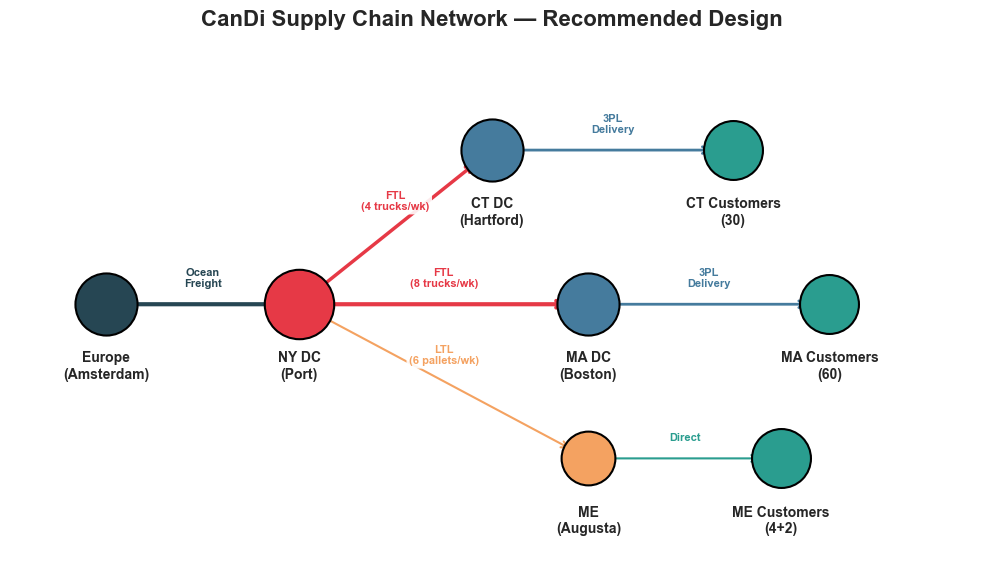

In [23]:
# ── Supply Chain Network Visualization ──
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("#f2f2f2")

# Node positions
positions = {
    'Europe\n(Amsterdam)': (1, 5),
    'NY DC\n(Port)': (3, 5),
    'CT DC\n(Hartford)': (5, 7),
    'MA DC\n(Boston)': (6, 5),
    'ME\n(Augusta)': (6, 3),
    'CT Customers\n(30)': (7.5, 7),
    'MA Customers\n(60)': (8.5, 5),
    'ME Customers\n(4+2)': (8, 3),
}

# Draw nodes + labels
for name, (x, y) in positions.items():
    if 'Europe' in name:
        color, size = '#264653', 2000
    elif 'NY' in name:
        color, size = '#E63946', 2500
    elif 'DC' in name:
        color, size = '#457B9D', 2000
    elif 'Customer' in name:
        color, size = '#2A9D8F', 1800
    else:
        color, size = '#F4A261', 1500

    ax.scatter(x, y, s=size, c=color, zorder=5, edgecolors='black', linewidth=1.5)

    # Push labels lower and force them above all plot elements
    ax.annotate(
        name, (x, y), textcoords="offset points", xytext=(0, -34),
        ha='center', va='top', fontsize=10, fontweight='bold',
        zorder=20, clip_on=False,
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.75, edgecolor='none')
    )

# Draw edges (flows)
edges = [
    ('Europe\n(Amsterdam)', 'NY DC\n(Port)', 'Ocean\nFreight', '#264653', 3),
    ('NY DC\n(Port)', 'CT DC\n(Hartford)', 'FTL\n(4 trucks/wk)', '#E63946', 2.5),
    ('NY DC\n(Port)', 'MA DC\n(Boston)', 'FTL\n(8 trucks/wk)', '#E63946', 3),
    ('NY DC\n(Port)', 'ME\n(Augusta)', 'LTL\n(6 pallets/wk)', '#F4A261', 1.5),
    ('CT DC\n(Hartford)', 'CT Customers\n(30)', '3PL\nDelivery', '#457B9D', 2),
    ('MA DC\n(Boston)', 'MA Customers\n(60)', '3PL\nDelivery', '#457B9D', 2),
    ('ME\n(Augusta)', 'ME Customers\n(4+2)', 'Direct', '#2A9D8F', 1.5),
]

for start, end, label, color, width in edges:
    sx, sy = positions[start]
    ex, ey = positions[end]
    ax.annotate(
        '', xy=(ex, ey), xytext=(sx, sy),
        arrowprops=dict(arrowstyle='->', color=color, lw=width, shrinkA=15, shrinkB=15),
        zorder=3
    )
    mx, my = (sx + ex) / 2, (sy + ey) / 2 + 0.22
    ax.text(
        mx, my, label, fontsize=8, ha='center', color=color, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.9, edgecolor='none'),
        zorder=10
    )

ax.set_xlim(0, 10)
ax.set_ylim(1.5, 8.5)
ax.set_title('CanDi Supply Chain Network — Recommended Design', fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.savefig('network_design.png', dpi=150, bbox_inches='tight')
plt.show()

## Part 8: Executive Summary & Final Recommendations

### Recommended Supply Chain Design

After thorough quantitative and qualitative analysis, here are our recommendations:

---

### 1. Warehouse Network: Open CT and MA Regional DCs

The corrected model (using LTL for direct customer delivery, since no customer fills a truck) shows that **regional DCs are strongly justified economically**:

| Configuration | Annual Cost | vs. No DCs |
|--------------|-------------|------------|
| **No DCs** (all direct LTL) | ~\$2.7M | Baseline |
| **MA only** | ~\$2.1M | Saves ~\$600K |
| **CT + MA** (recommended) | ~\$1.7M | **Saves ~\$1M** |
| **All 3 DCs** | ~\$1.9M | ME DC not justified |

**Why Regional DCs win:** They enable FTL trunk-line shipping from NY (\$0.02-0.04/bag) instead of LTL to each customer (\$0.125-0.25/bag). The FTL savings more than offset the warehouse fixed costs and variable handling.

### 2. Transportation Strategy

| Route | Mode | Volume | Rationale |
|-------|------|--------|-----------|
| **NY → CT DC** | FTL + LTL | ~95 pallets/wk (4+ trucks) | Bulk replenishment, cheap per bag |
| **NY → MA DC** | FTL + LTL | ~170 pallets/wk (8+ trucks) | Bulk replenishment, cheap per bag |
| **NY → ME customers** | Leased truck | ~9 pallets/wk (1 truck) | Multi-stop; cheaper than LTL at \$1,800 vs \$2,500 |
| **CT DC → Customers** | 3PL | Per customer | \$15/pallet; 3PL coordinates delivery windows |
| **MA DC → Customers** | 3PL | Per customer | \$15/pallet; 3PL coordinates delivery windows |

### 3. Why This Matters Operationally

The PDF warns: *"If we deliver directly to customer DCs from NY, we have to take care of delivery window coordination."* Customer DCs enforce **strict FTL delivery windows** ("Tuesday between 6-6:15am"). By routing through regional DCs:

- The **3PL logistics provider handles all customer delivery coordination**
- CanDi only manages simple FTL bulk shipments (easy to schedule)
- This is critical for a **young, small company** without dedicated logistics operations

### 4. Inventory Policy

- **System**: Periodic Review (R, S) — Order-Up-To
- **Review Period**: 1 week (matches customer ordering cycle)
- **Service Level**: 95% (z = 1.645)
- **Safety stock**: ~37 pallets total across both DCs
- **Inventory turns**: 60-93x/year depending on segment

### 5. Mixed Pallet Surcharge Impact

The \$1/box surcharge for mixed pallets adds ~\$117K/year (CT+MA DCs). This disproportionately affects **Tail** (100% mixed) and **Connoisseur** (100% mixed) segments. Despite this cost, the FTL savings from regional DCs still dominate.

### 6. Maine Decision

**Do NOT open a Maine DC.** With only ~9 pallets/week (4% of volume), the \$200K fixed cost is unjustifiable. A weekly leased truck from NY (\$1,800/day = \$93,600/year) is much cheaper than a DC (\$358K/year with all costs).

---

*Analysis performed with corrected transportation model accounting for per-customer delivery constraints, mixed pallet surcharges, and FTL point-to-point limitations.*
